<a href="https://colab.research.google.com/github/zerxe/2D_Game_PGL/blob/main/SNS/SNS_Actividad_3_7_Predicci%C3%B3n_de_Riesgo_de_derrumbamiento_Terremotos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adolfo Morales Colmenares


# Actividad 3.7 Predicción de Riesgo de derrumbamiento - Terremotos

## Imports

Instalación en el entorno del colab el paquete LazyPredict


In [23]:
!pip install lazypredict

In [24]:
import warnings
import os
import pickle
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, ParameterSampler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from lazypredict.Supervised import LazyClassifier
import lazypredict
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from scipy.cluster import hierarchy
from tqdm.notebook import tqdm

## Carga del dataset

In [25]:
train_values = pd.read_csv("https://raw.githubusercontent.com/zerxe/CEIABDAT/refs/heads/main/SNS/earthquake_train_values.csv")
train_labels = pd.read_csv("https://raw.githubusercontent.com/zerxe/CEIABDAT/refs/heads/main/SNS/earthquake_train_labels.csv")
test_values  = pd.read_csv("https://raw.githubusercontent.com/zerxe/CEIABDAT/refs/heads/main/SNS/earthquake_test_values.csv")

## Gráficas de los datos

In [26]:
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('fivethirtyeight')
sns.set_palette("Set2")

train_data = pd.merge(train_values, train_labels, on="building_id")

### Distribución del daño en base al nivel de daño y numero de construcciones

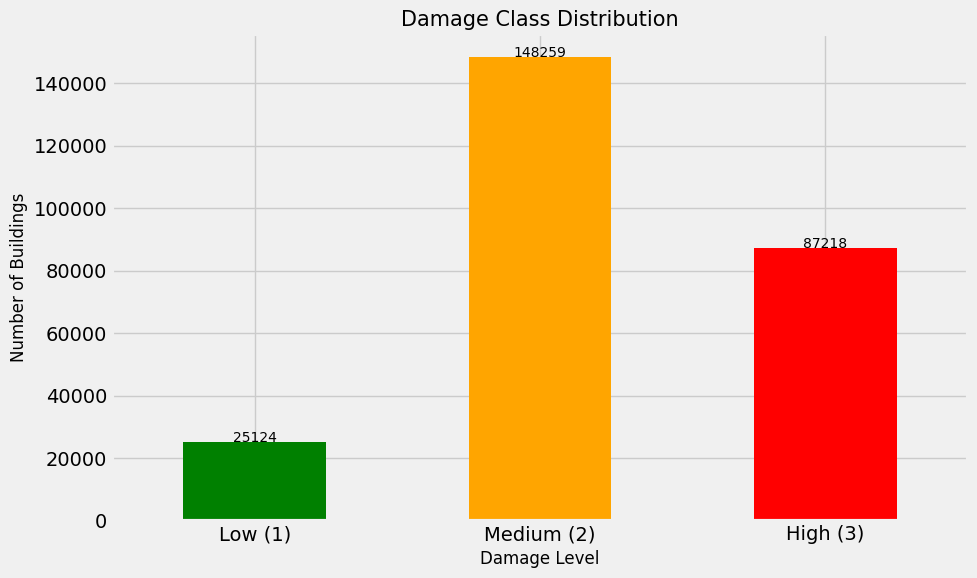

In [27]:
plt.figure(figsize=(10, 6))
damage_counts = train_data['damage_grade'].value_counts().sort_index()
ax = damage_counts.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Damage Class Distribution', fontsize=15)
plt.xlabel('Damage Level', fontsize=12)
plt.ylabel('Number of Buildings', fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['Low (1)', 'Medium (2)', 'High (3)'], rotation=0)

for i, v in enumerate(damage_counts):
    ax.text(i, v + 50, str(v), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### Explorando características numéricas

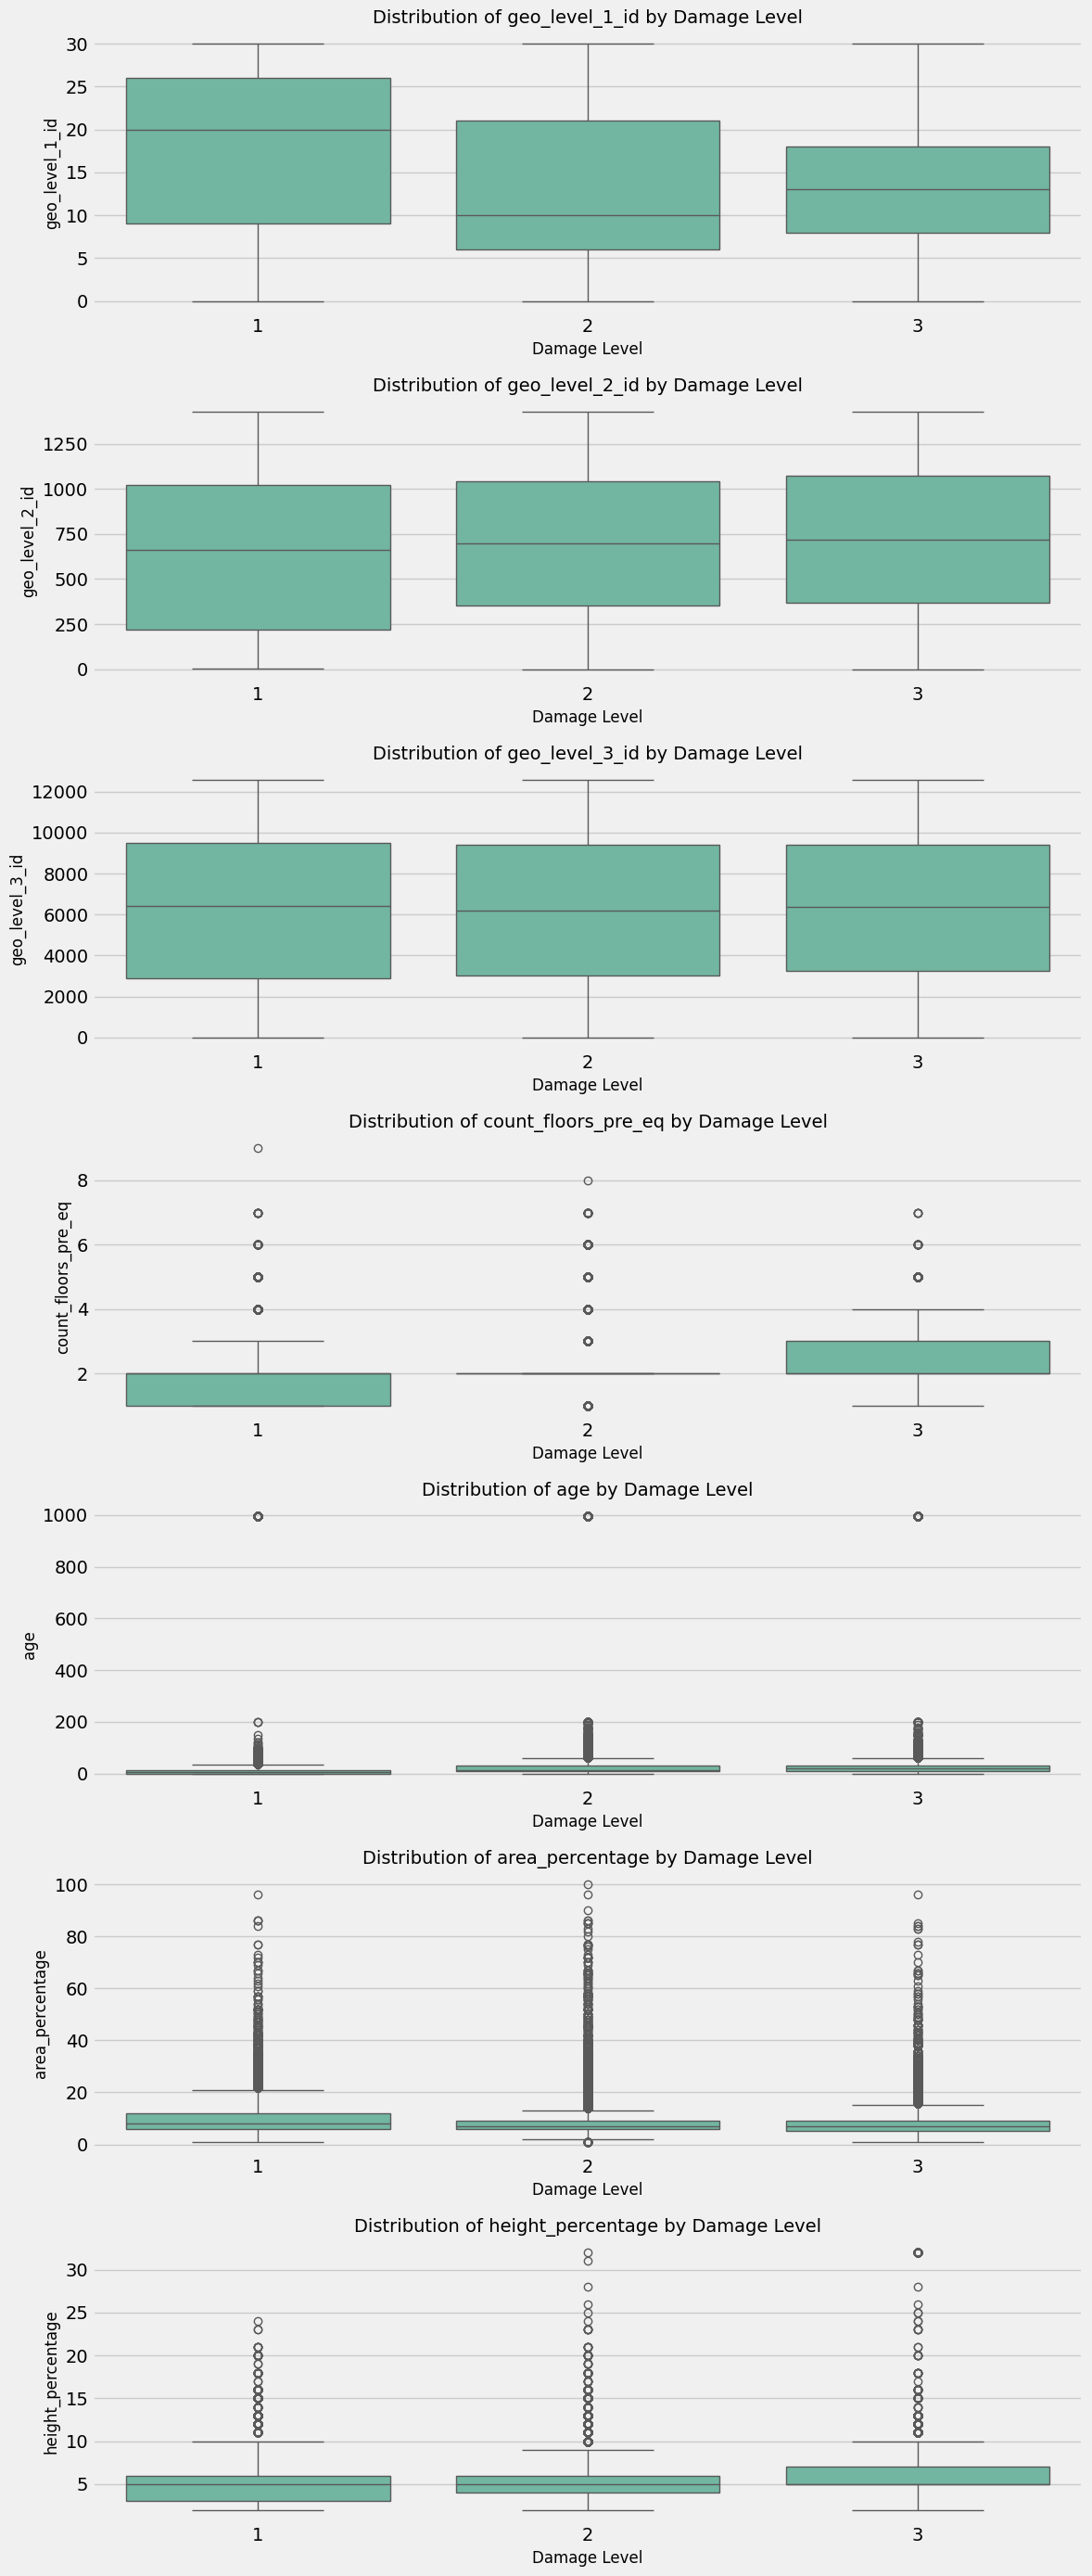

In [28]:
numerical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq',
                      'age', 'area_percentage', 'height_percentage']

fig, axes = plt.subplots(len(numerical_features), 1, figsize=(12, 4*len(numerical_features)))
for i, feature in enumerate(numerical_features):
    sns.boxplot(x='damage_grade', y=feature, data=train_data, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by Damage Level', fontsize=14)
    axes[i].set_xlabel('Damage Level', fontsize=12)
    axes[i].set_ylabel(feature, fontsize=12)

plt.tight_layout()
plt.show()

## Matriz de correlación de características numéricas

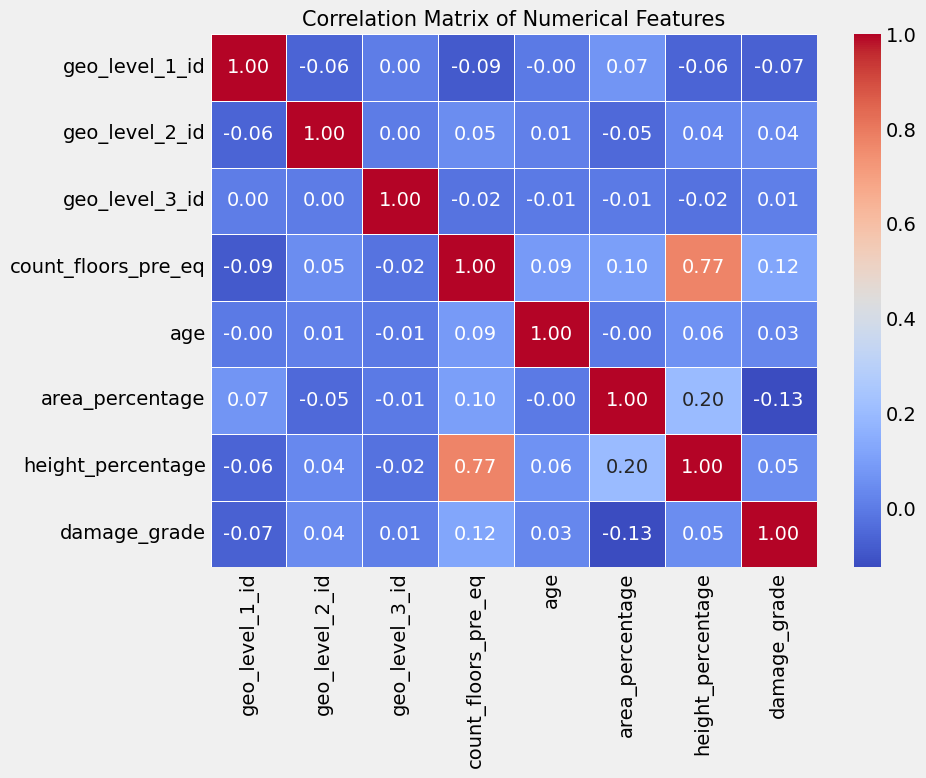

In [29]:
# Correlation matrix of numerical features
plt.figure(figsize=(10, 8))
correlation_matrix = train_data[numerical_features + ['damage_grade']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=15)
plt.tight_layout()
plt.show()

## Análisis de las características categóricas

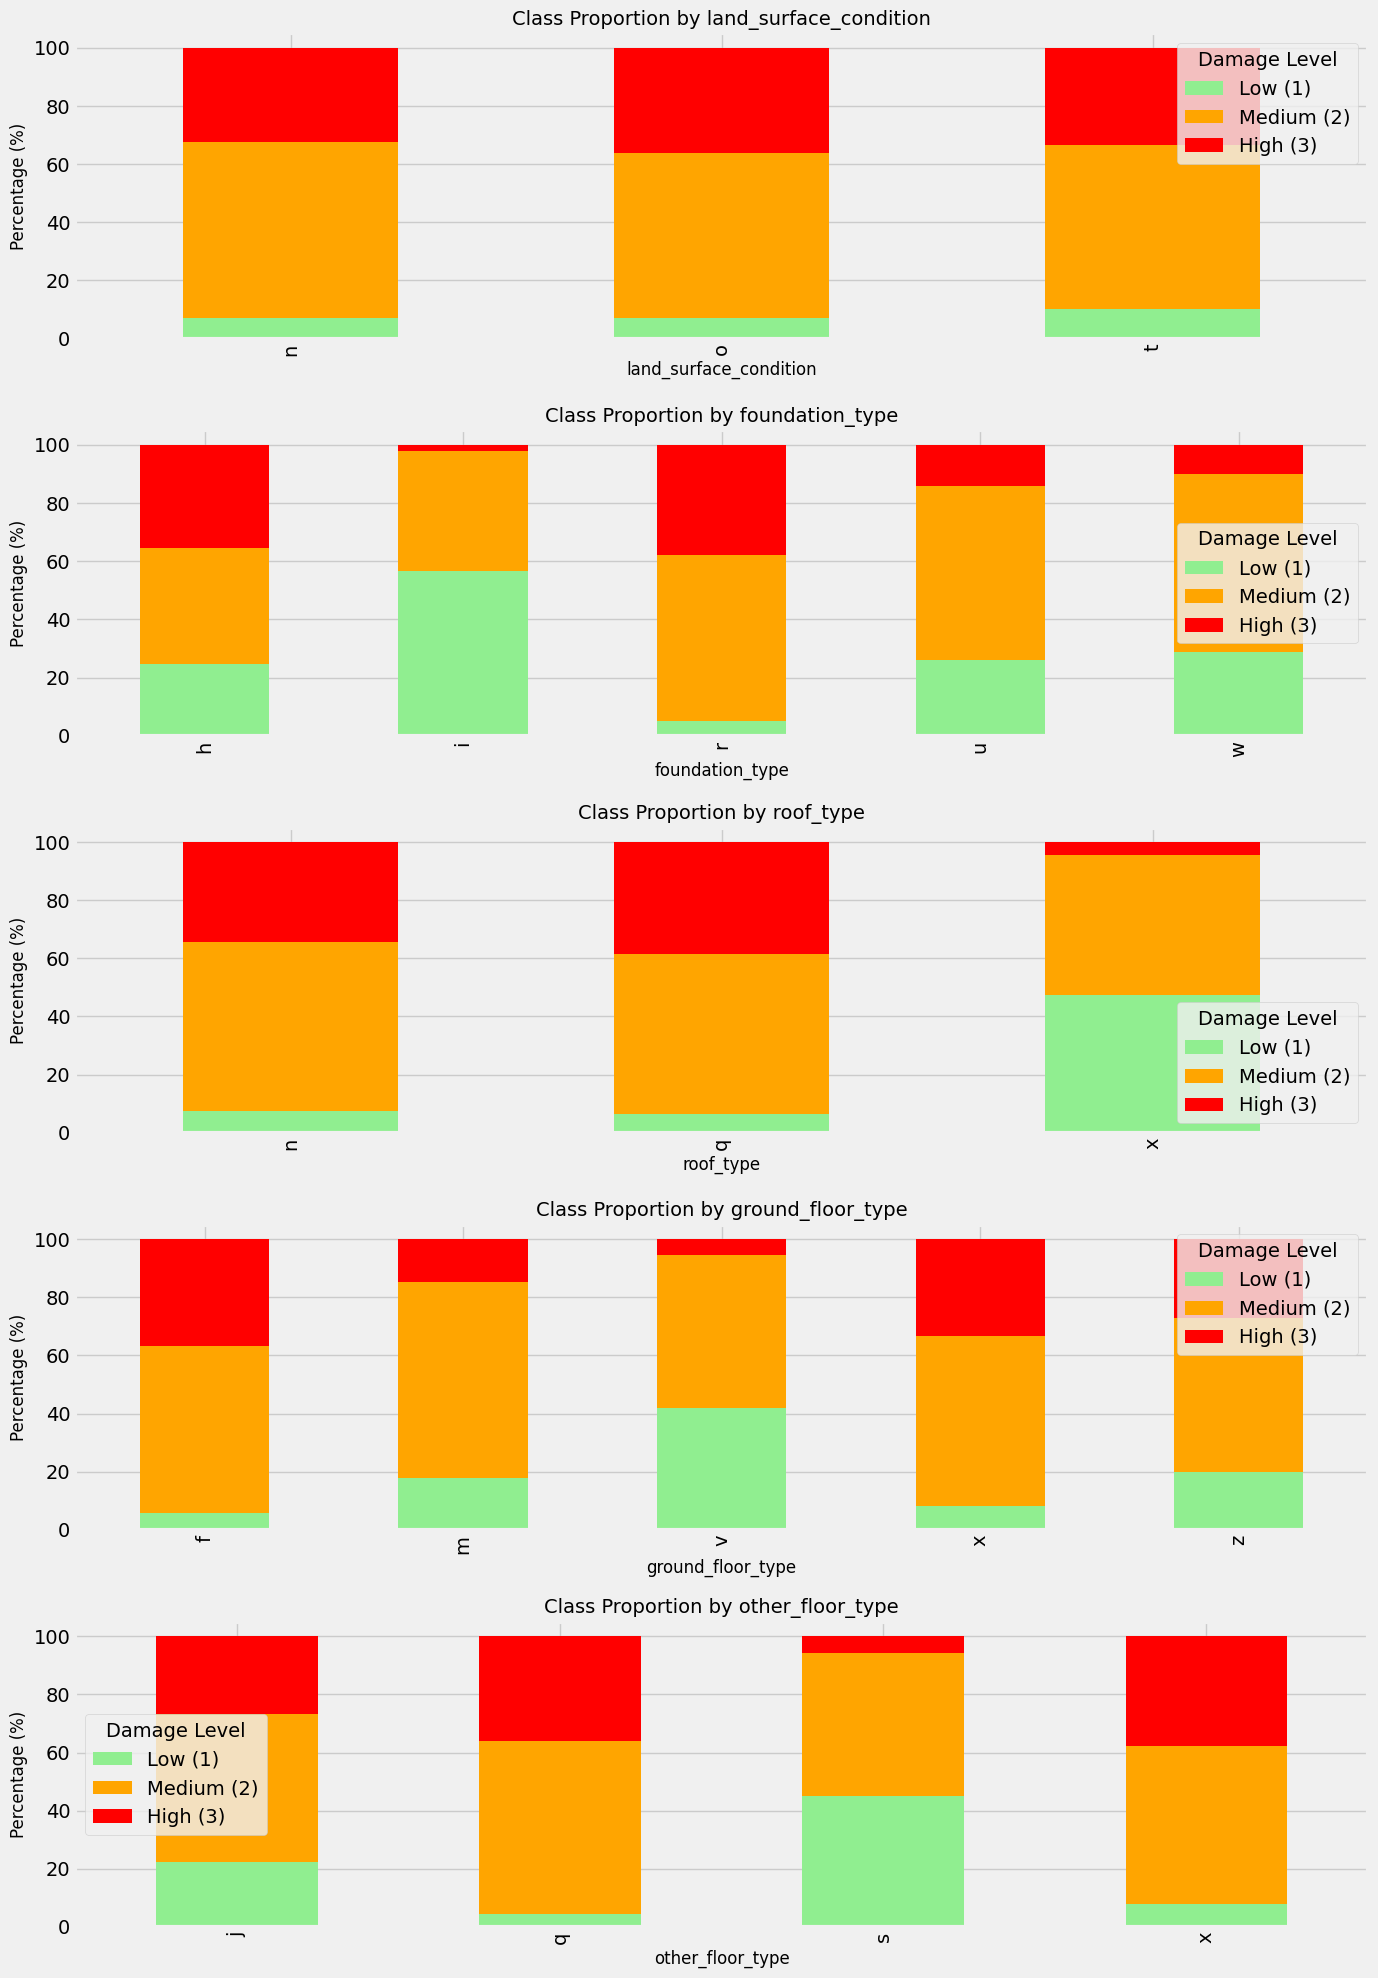

In [30]:
categorical_features = ['land_surface_condition', 'foundation_type', 'roof_type',
                        'ground_floor_type', 'other_floor_type']

fig, axes = plt.subplots(len(categorical_features), 1, figsize=(14, 4*len(categorical_features)))
for i, feature in enumerate(categorical_features):
    cat_proportions = pd.crosstab(train_data[feature], train_data['damage_grade'],
                                  normalize='index') * 100
    cat_proportions.plot(kind='bar', stacked=True, ax=axes[i],
                         color=['lightgreen', 'orange', 'red'])
    axes[i].set_title(f'Class Proportion by {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Percentage (%)', fontsize=12)
    axes[i].legend(title='Damage Level', labels=['Low (1)', 'Medium (2)', 'High (3)'])

plt.tight_layout()
plt.show()

## Uso del dendograma

### Dendograma


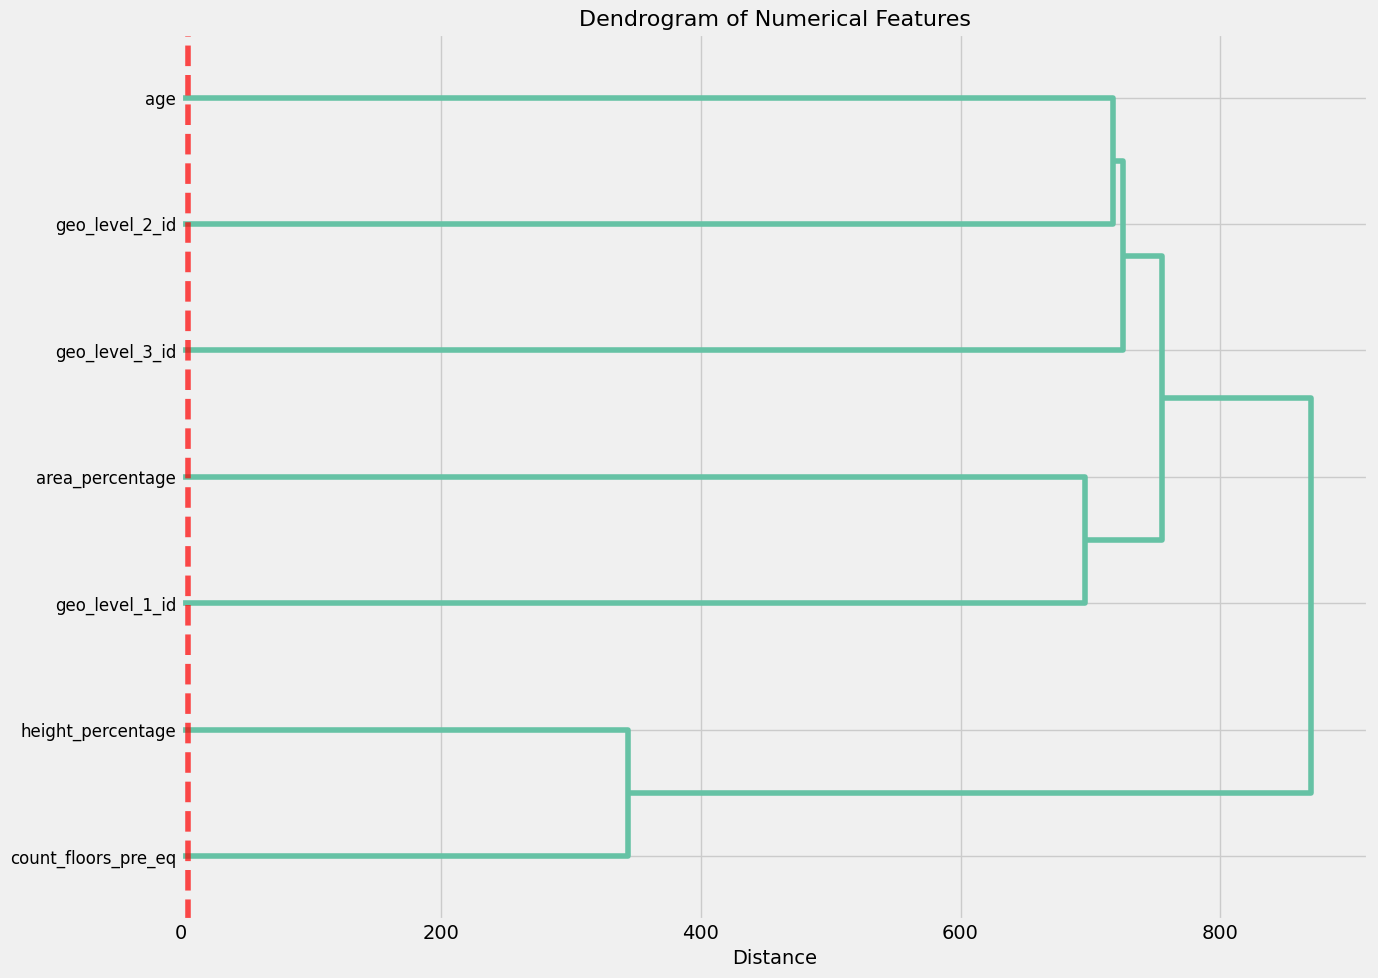

In [31]:
X_scaled = StandardScaler().fit_transform(train_data[numerical_features])

plt.figure(figsize=(14, 10))
dend = hierarchy.dendrogram(
    hierarchy.linkage(X_scaled.T, method='ward'),
    labels=numerical_features,
    orientation='right',
    leaf_font_size=12,
    color_threshold=5
)
plt.title('Dendrogram of Numerical Features', fontsize=16)
plt.xlabel('Distance', fontsize=14)
plt.axvline(x=5, color='red', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Transformacion de características categórica a numéricas para matriz de correlación

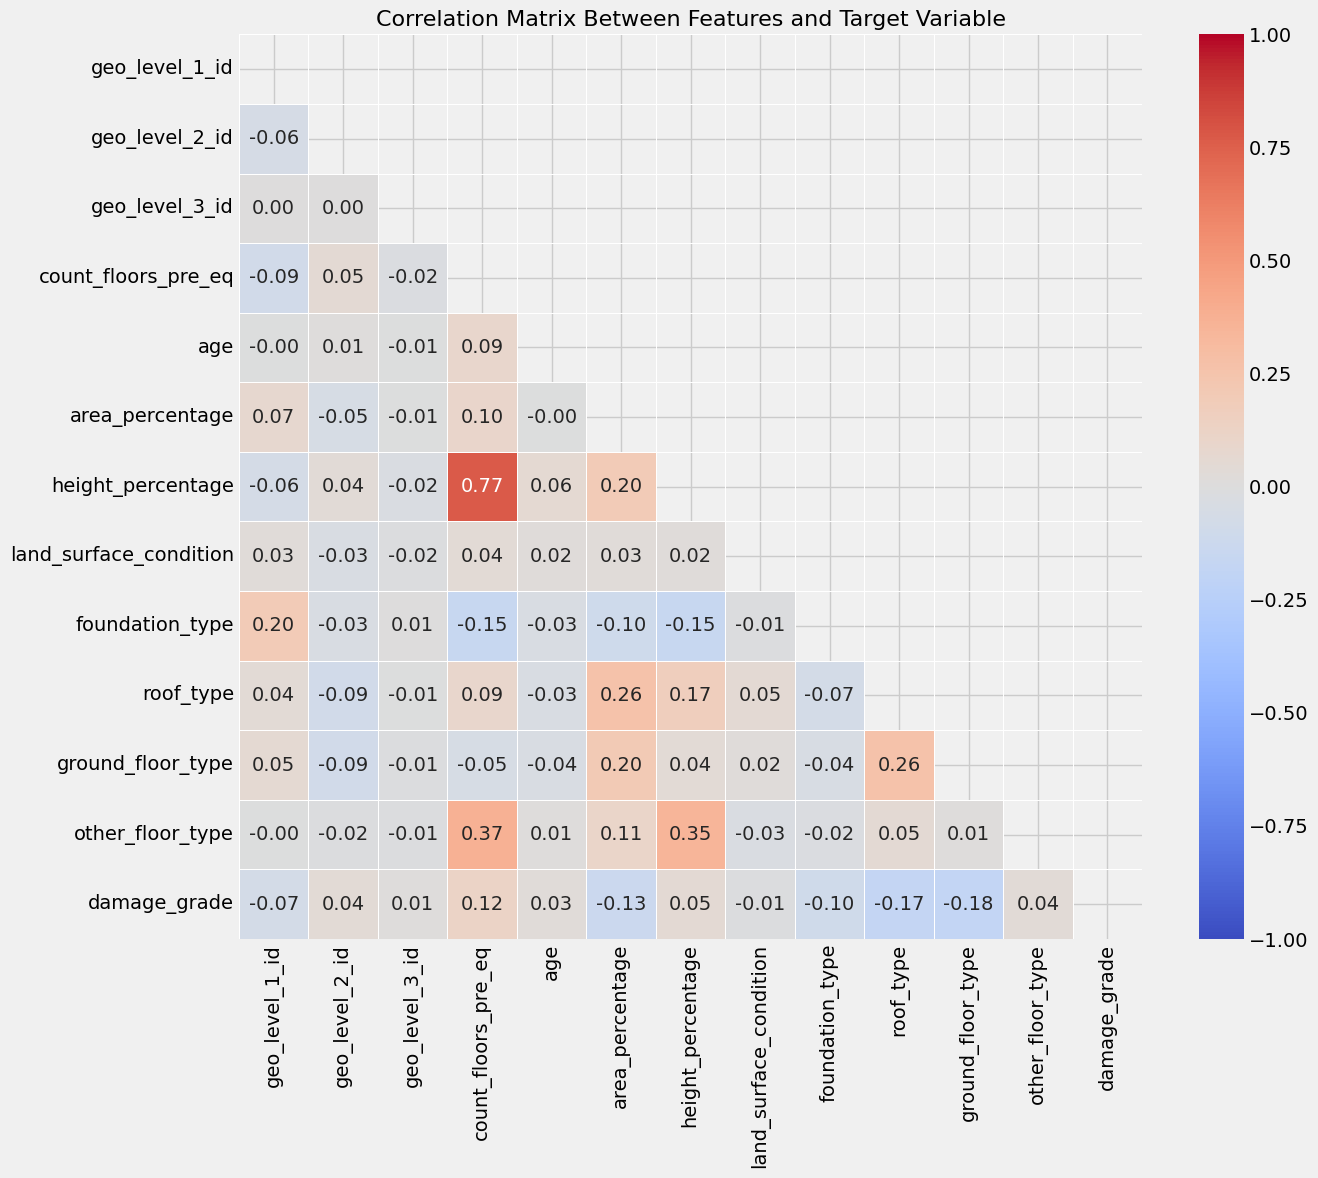

In [32]:
def convert_categorical_to_numeric(df, categorical_cols):
    return df[categorical_cols].apply(lambda col: col.astype('category').cat.codes)

categorical_cols = [col for col in train_data.columns if train_data[col].dtype == 'object' and col != 'building_id']
train_data_encoded = train_data.copy()
train_data_encoded[categorical_cols] = convert_categorical_to_numeric(train_data, categorical_cols)

selected_features = numerical_features + categorical_cols[:5] + ['damage_grade']

plt.figure(figsize=(14, 12))
correlation = train_data_encoded[selected_features].corr()
sns.heatmap(correlation, mask=np.triu(np.ones_like(correlation, dtype=bool)),
            annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix Between Features and Target Variable', fontsize=16)
plt.tight_layout()
plt.show()

Seleccionando las características relevantes basado en el dendograma y la matriz de correlación anterior

In [33]:
binary_columns = []
for col in train_values.columns:
    unique_vals = train_values[col].unique()
    if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
        binary_columns.append(col)

selected_features = [
    'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
    'land_surface_condition', 'foundation_type', 'roof_type',
    'ground_floor_type', 'other_floor_type'
]

selected_features += binary_columns[:10]

print("Selected features for modeling:", selected_features)

Selected features for modeling: ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered']


##  Preprocesamiento de datos y selección de muestra

Sampling strategy:
- Stratified sampling with geographic diversity and structural characteristics.


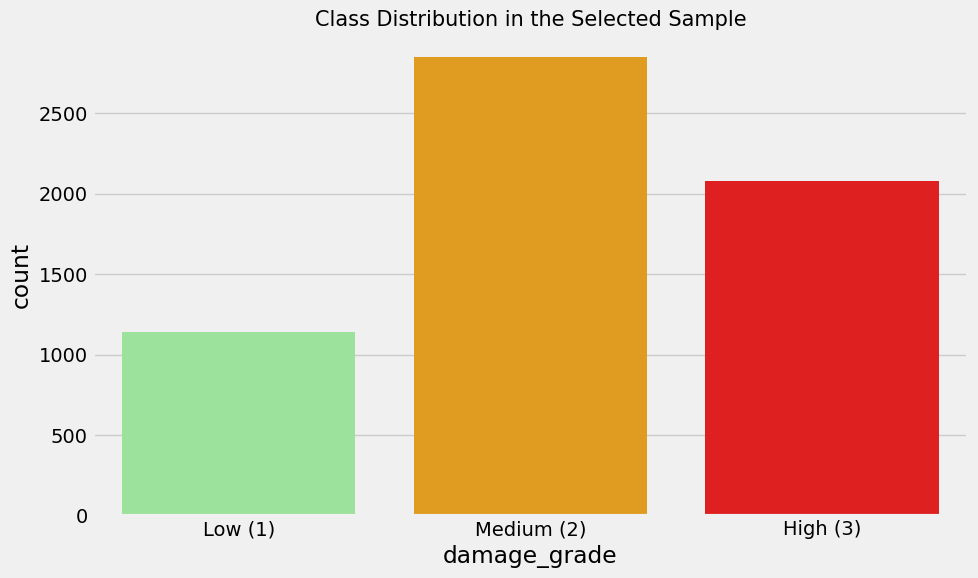

Training set size: 4857 samples
Test set size: 1215 samples


In [34]:
# Preprocessing the data
X = train_data.drop(['building_id', 'damage_grade'], axis=1)  # Drop irrelevant columns
y = train_data['damage_grade']  # Target variable

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# Explanation of the sampling strategy
print("Sampling strategy:\n- Stratified sampling with geographic diversity and structural characteristics.")

# Advanced sampling function to ensure diverse and representative samples
def advanced_sampling(df, y, sample_size):
    geo_groups = df.groupby(['geo_level_1_id', 'geo_level_2_id'])
    sampled_indices = []

    for name, group in geo_groups:
        group_size = len(group)
        group_sample_size = max(1, int(group_size / len(df) * sample_size))

        for damage_level in [1, 2, 3]:
            damage_indices = group[y == damage_level].index
            if len(damage_indices) > 0:
                damage_sample_size = max(1, int(group_sample_size * (sum(y[group.index] == damage_level) / group_size)))
                sorted_indices = df.loc[damage_indices].sort_values(by=['age', 'count_floors_pre_eq', 'area_percentage']).index[:damage_sample_size]
                sampled_indices.extend(sorted_indices)

    if len(sampled_indices) < sample_size:
        remaining = sample_size - len(sampled_indices)
        additional_indices = df.sort_values(by=['foundation_type', 'roof_type', 'height_percentage']).index[:remaining]
        sampled_indices.extend(additional_indices)

    return df.loc[sampled_indices], y.loc[sampled_indices]

# Calculate the sample size (2% of the total dataset)
sample_size = int(0.02 * len(train_data))

# Apply the advanced sampling method
X_sampled, y_sampled = advanced_sampling(X, y, sample_size)

# Check class distribution in the sampled data
plt.figure(figsize=(10, 6))
sns.countplot(x=y_sampled, palette=['lightgreen', 'orange', 'red'])
plt.title('Class Distribution in the Selected Sample', fontsize=15)
plt.xticks([0, 1, 2], ['Low (1)', 'Medium (2)', 'High (3)'])
plt.tight_layout()
plt.show()

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled)

# Display sizes of training and testing sets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Define preprocessor for scaling and encoding
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),  # Scale numerical features
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical features
])

# Apply preprocessing to the training and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Save preprocessor for future use
with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

## Lazy predict

In [35]:
# Run LazyPredict to quickly compare multiple models
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit models to the training and testing data
models, predictions = clf.fit(X_train_processed, X_test_processed, y_train, y_test)

# Display the results of all models
print("Model Comparison using LazyPredict:")
display(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 749
[LightGBM] [Info] Number of data points in the train set: 4857, number of used features: 54
[LightGBM] [Info] Start training from score -1.671440
[LightGBM] [Info] Start training from score -0.756684
[LightGBM] [Info] Start training from score -1.070596
Model Comparison using LazyPredict:


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.57,0.52,None,0.56,0.44
BernoulliNB,0.48,0.51,None,0.46,0.06
NearestCentroid,0.45,0.50,None,0.40,0.04
RandomForestClassifier,0.56,0.50,None,0.55,1.32
BaggingClassifier,0.53,0.49,None,0.52,0.62
DecisionTreeClassifier,0.49,0.47,None,0.49,0.08
LogisticRegression,0.54,0.47,None,0.52,0.13
LinearDiscriminantAnalysis,0.51,0.47,None,0.50,0.15
ExtraTreesClassifier,0.51,0.47,None,0.50,1.15


### Top 15 por Accuracy

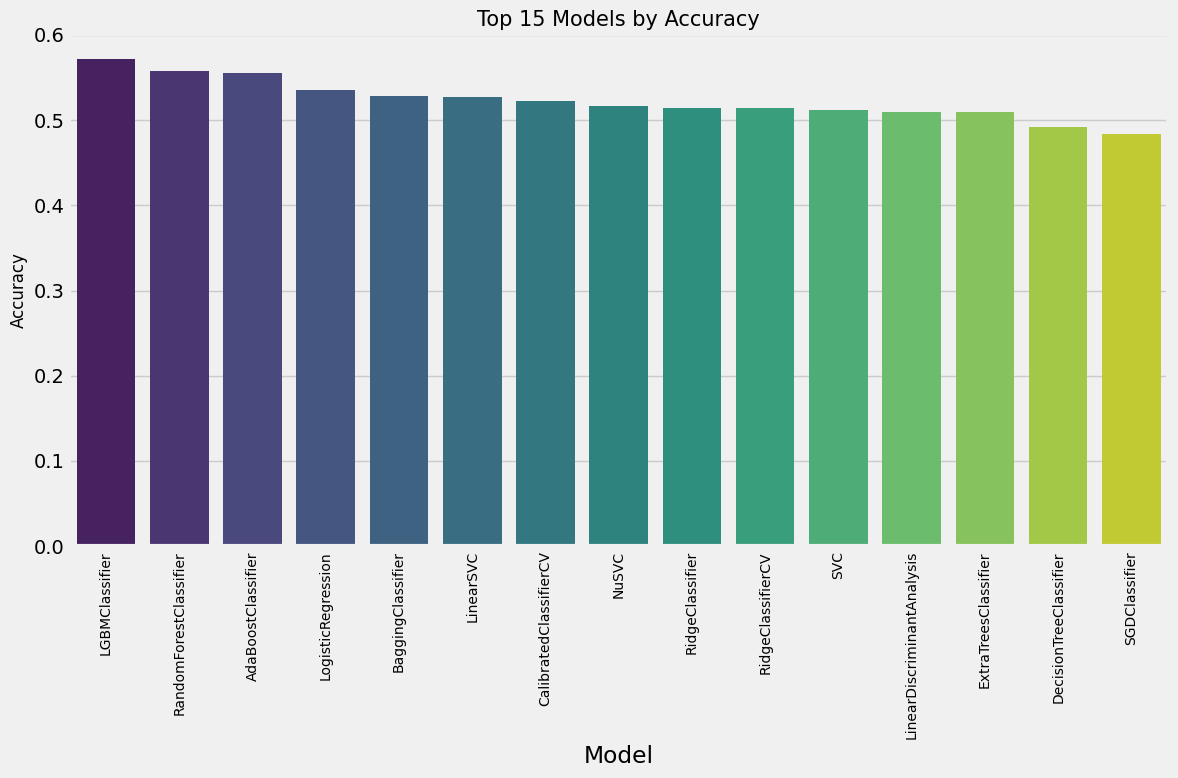

In [36]:
# Visualizing the top 15 models by accuracy
plt.figure(figsize=(12, 8))
# Sort models by accuracy and select the top 15
models_accuracy = models.sort_values(by='Accuracy', ascending=False)[:15]
# Create a barplot for accuracy
sns.barplot(x=models_accuracy.index, y=models_accuracy['Accuracy'], palette='viridis')
plt.title('Top 15 Models by Accuracy', fontsize=15)
plt.xticks(rotation=90, fontsize=10)  # Rotate labels for better readability
plt.ylabel('Accuracy', fontsize=12)
plt.tight_layout()
plt.show()

Top 15 por F1 Score

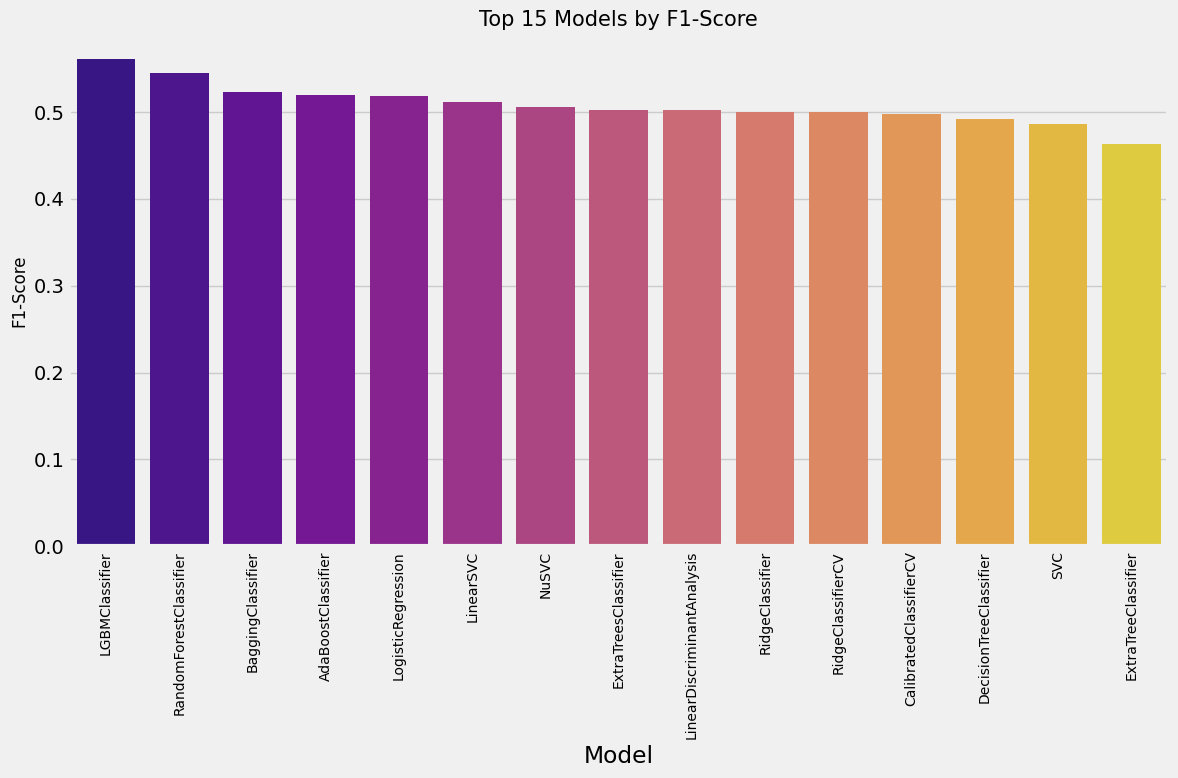

In [37]:
# Visualizing the top 15 models by F1-Score (our main evaluation metric)
plt.figure(figsize=(12, 8))
# Sort models by F1-Score and select the top 15
models_f1 = models.sort_values(by='F1 Score', ascending=False)[:15]
# Create a barplot for F1-Score
sns.barplot(x=models_f1.index, y=models_f1['F1 Score'], palette='plasma')
plt.title('Top 15 Models by F1-Score', fontsize=15)
plt.xticks(rotation=90, fontsize=10)  # Rotate labels for better readability
plt.ylabel('F1-Score', fontsize=12)
plt.tight_layout()
plt.show()

## Models

### Tree Models

#### BeggingClassifier

Starting optimization for BaggingClassifier... (you’ll see the progress here!)


Optimizing BaggingClassifier:   0%|          | 0/20 [00:00<?, ?it/s]


New best F1-score: 0.4956 with these parameters:
  n_estimators: 10
  max_samples: 1.0
  max_features: 1.0
  estimator__min_samples_split: 2
  estimator__min_samples_leaf: 2
  estimator__max_depth: 20
  bootstrap: False

New best F1-score: 0.5637 with these parameters:
  n_estimators: 100
  max_samples: 1.0
  max_features: 0.5
  estimator__min_samples_split: 2
  estimator__min_samples_leaf: 4
  estimator__max_depth: 10
  bootstrap: True

New best F1-score: 0.5648 with these parameters:
  n_estimators: 100
  max_samples: 0.7
  max_features: 0.5
  estimator__min_samples_split: 10
  estimator__min_samples_leaf: 1
  estimator__max_depth: 10
  bootstrap: False

New best F1-score: 0.5672 with these parameters:
  n_estimators: 100
  max_samples: 0.5
  max_features: 0.5
  estimator__min_samples_split: 10
  estimator__min_samples_leaf: 4
  estimator__max_depth: 10
  bootstrap: False

Training complete.
Best parameters for BaggingClassifier:
Base estimator parameters:
  min_samples_split: 10
  

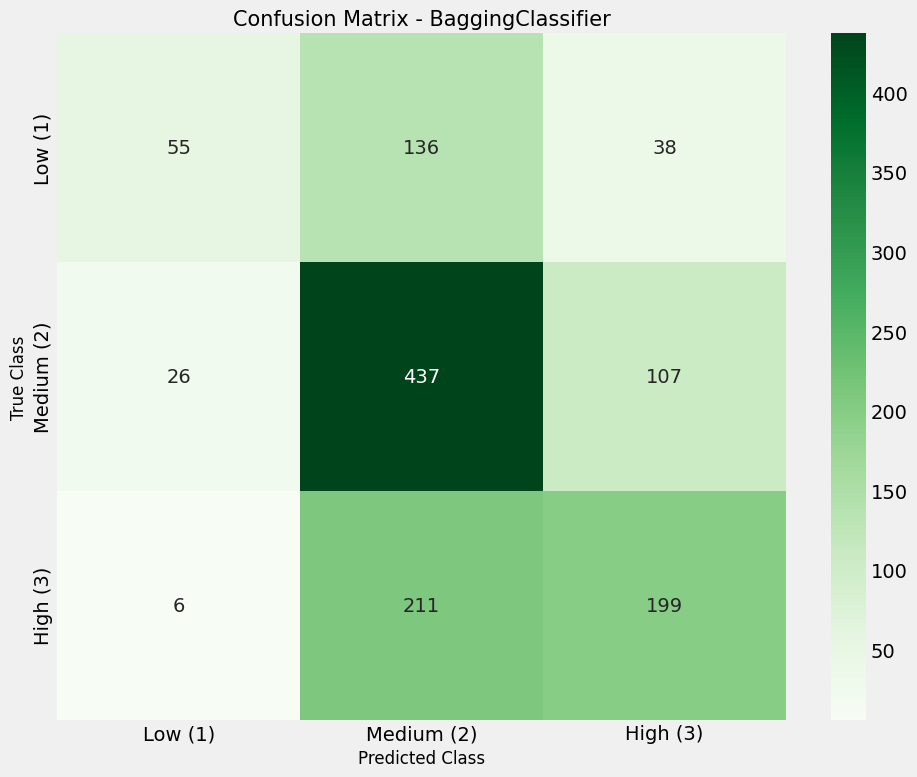

Classification report - BaggingClassifier:
              precision    recall  f1-score   support

           1       0.63      0.24      0.35       229
           2       0.56      0.77      0.65       570
           3       0.58      0.48      0.52       416

    accuracy                           0.57      1215
   macro avg       0.59      0.50      0.51      1215
weighted avg       0.58      0.57      0.55      1215



In [38]:
# First, we’ll set up our model using a DecisionTree as the base estimator inside a BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
base_estimator = DecisionTreeClassifier(random_state=42)
bagging_model = BaggingClassifier(estimator=base_estimator, random_state=42, n_jobs=-1)

# Now, we define the parameters that we'll test to optimize the model.
param_dist_bagging = {
    'n_estimators': [10, 50, 100],  # Number of base estimators (trees) in the bagging ensemble
    'max_samples': [0.5, 0.7, 1.0],  # Fraction of samples to train each base estimator on
    'max_features': [0.5, 0.7, 1.0],  # Fraction of features to use for each base estimator
    'bootstrap': [True, False],  # Whether or not to sample with replacement
    'estimator__max_depth': [None, 10, 20],  # Maximum depth of each tree (helps prevent overfitting)
    'estimator__min_samples_split': [2, 5, 10],  # Minimum samples needed to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4]  # Minimum samples needed to be at a leaf node
}

# We generate random combinations of the above parameters to try out
param_list = list(ParameterSampler(param_dist_bagging, n_iter=20, random_state=42))

# We will store the results of each parameter combination here
best_score = 0
best_params = None
results = []

# Set up cross-validation with 3 splits
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# We’ll now run a loop to optimize the BaggingClassifier model
print("Starting optimization for BaggingClassifier... (you’ll see the progress here!)")
for params in tqdm(param_list, desc="Optimizing BaggingClassifier"):
    # We separate parameters for the base estimator and the BaggingClassifier itself
    estimator_params = {}
    bagging_params = {}

    for key, value in params.items():
        if key.startswith('estimator__'):
            # Extract the parameter name without the 'estimator__' prefix
            param_name = key.replace('estimator__', '')
            estimator_params[param_name] = value
        else:
            bagging_params[key] = value

    # Now, create the base estimator (decision tree) with the extracted parameters
    base_est = DecisionTreeClassifier(random_state=42, **estimator_params)

    # Create the BaggingClassifier with the base estimator and other parameters
    model = BaggingClassifier(estimator=base_est, random_state=42, n_jobs=-1, **bagging_params)

    scores = []

    # Perform manual cross-validation
    for train_idx, val_idx in cv.split(X_train_processed, y_train):
        # Extract the data for this fold
        X_fold_train, X_fold_val = X_train_processed[train_idx], X_train_processed[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model on the fold's training data and make predictions
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)

        # Calculate the F1-score for the fold
        score = f1_score(y_fold_val, y_pred, average='micro')
        scores.append(score)

    # Calculate the average F1-score across all folds
    mean_score = np.mean(scores)
    results.append((params, mean_score))

    # If this model has the best score so far, we save it
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print(f"\nNew best F1-score: {best_score:.4f} with these parameters:")
        for key, value in params.items():
            print(f"  {key}: {value}")

# After testing all the parameter combinations, we'll create the final model using the best parameters
# Separate the best parameters for the base estimator and BaggingClassifier
estimator_params = {}
bagging_params = {}

for key, value in best_params.items():
    if key.startswith('estimator__'):
        param_name = key.replace('estimator__', '')
        estimator_params[param_name] = value
    else:
        bagging_params[key] = value

# Create the final base estimator with the best parameters
best_base_estimator = DecisionTreeClassifier(random_state=42, **estimator_params)

# Create the final BaggingClassifier model
best_bagging = BaggingClassifier(
    estimator=best_base_estimator,
    random_state=42,
    n_jobs=-1,
    **bagging_params
)

# Train the final model on the full training set
best_bagging.fit(X_train_processed, y_train)

# Output the details about the best model and its parameters
print("\nTraining complete.")
print("Best parameters for BaggingClassifier:")
print("Base estimator parameters:")
for key, value in estimator_params.items():
    print(f"  {key}: {value}")
print("Bagging parameters:")
for key, value in bagging_params.items():
    print(f"  {key}: {value}")
print(f"Best F1-score in cross-validation: {best_score:.4f}")

# Evaluate the trained model on the test set
y_pred_bagging = best_bagging.predict(X_test_processed)

# Calculate and print the F1-score on the test set
bagging_f1 = f1_score(y_test, y_pred_bagging, average='micro')
print(f"F1-score (micro) on test set: {bagging_f1:.4f}")

# Visualize the confusion matrix to see how well the model performed on each class
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred_bagging)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Low (1)', 'Medium (2)', 'High (3)'],
            yticklabels=['Low (1)', 'Medium (2)', 'High (3)'])
plt.title('Confusion Matrix - BaggingClassifier', fontsize=15)
plt.ylabel('True Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.tight_layout()
plt.show()

# Print a detailed classification report for further analysis
print("Classification report - BaggingClassifier:")
print(classification_report(y_test, y_pred_bagging))

# Save the trained model to a file for future use
with open('bagging_model.pkl', 'wb') as file:
    pickle.dump(best_bagging, file)

#### LGBMClassifier

Starting optimization for maximum accuracy...


Optimizing LGBMClassifier for accuracy:   0%|          | 0/30 [00:00<?, ?it/s]


New accuracy record: 0.5347 with parameters:
  subsample: 0.8
  reg_lambda: 0.0
  reg_alpha: 0.0
  num_leaves: 31
  n_estimators: 1000
  min_split_gain: 0.0
  min_child_samples: 20
  max_depth: 11
  learning_rate: 0.1
  colsample_bytree: 0.8
  boosting: gbdt
Associated F1-score: 0.5347

New accuracy record: 0.5734 with parameters:
  subsample: 1.0
  reg_lambda: 0.1
  reg_alpha: 1.0
  num_leaves: 63
  n_estimators: 700
  min_split_gain: 0.0
  min_child_samples: 50
  max_depth: 7
  learning_rate: 0.01
  colsample_bytree: 0.8
  boosting: gbdt
Associated F1-score: 0.5734

New accuracy record: 0.5763 with parameters:
  subsample: 0.8
  reg_lambda: 0.0
  reg_alpha: 1.0
  num_leaves: 31
  n_estimators: 500
  min_split_gain: 0.0
  min_child_samples: 50
  max_depth: 11
  learning_rate: 0.05
  colsample_bytree: 0.8
  boosting: dart
Associated F1-score: 0.5763

Training the final model with the best parameters...

Training complete.
Best parameters for maximum accuracy: {'verbose': -1, 'subsampl

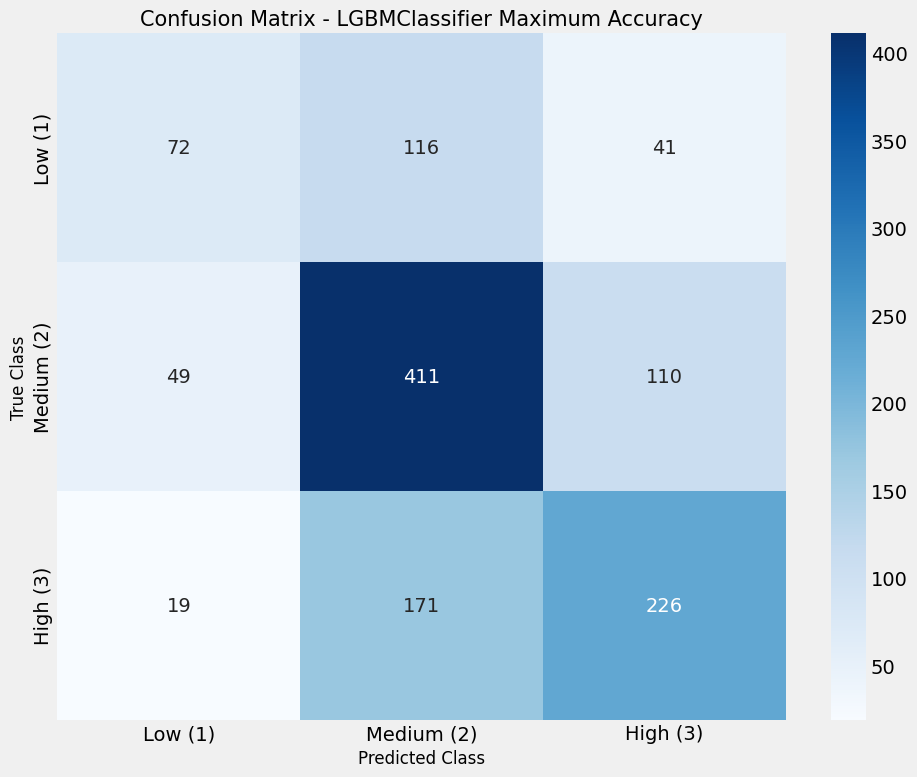


Classification report - Optimized LGBMClassifier for Accuracy:
              precision    recall  f1-score   support

           1       0.51      0.31      0.39       229
           2       0.59      0.72      0.65       570
           3       0.60      0.54      0.57       416

    accuracy                           0.58      1215
   macro avg       0.57      0.53      0.54      1215
weighted avg       0.58      0.58      0.57      1215



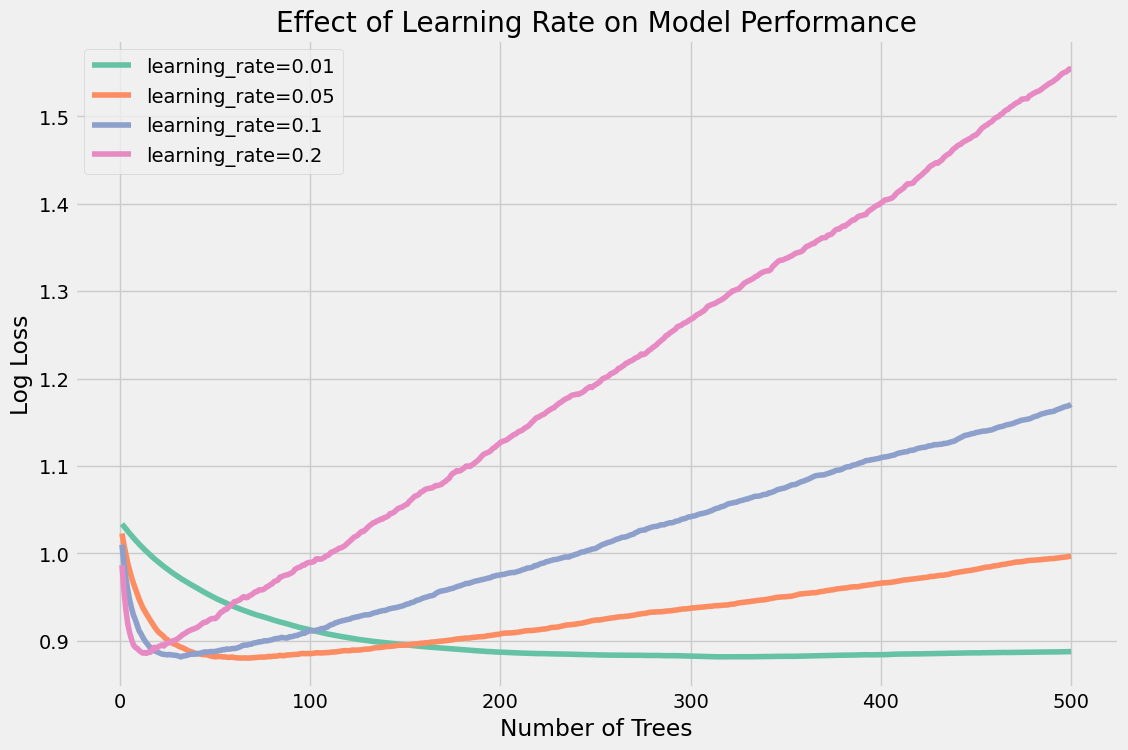

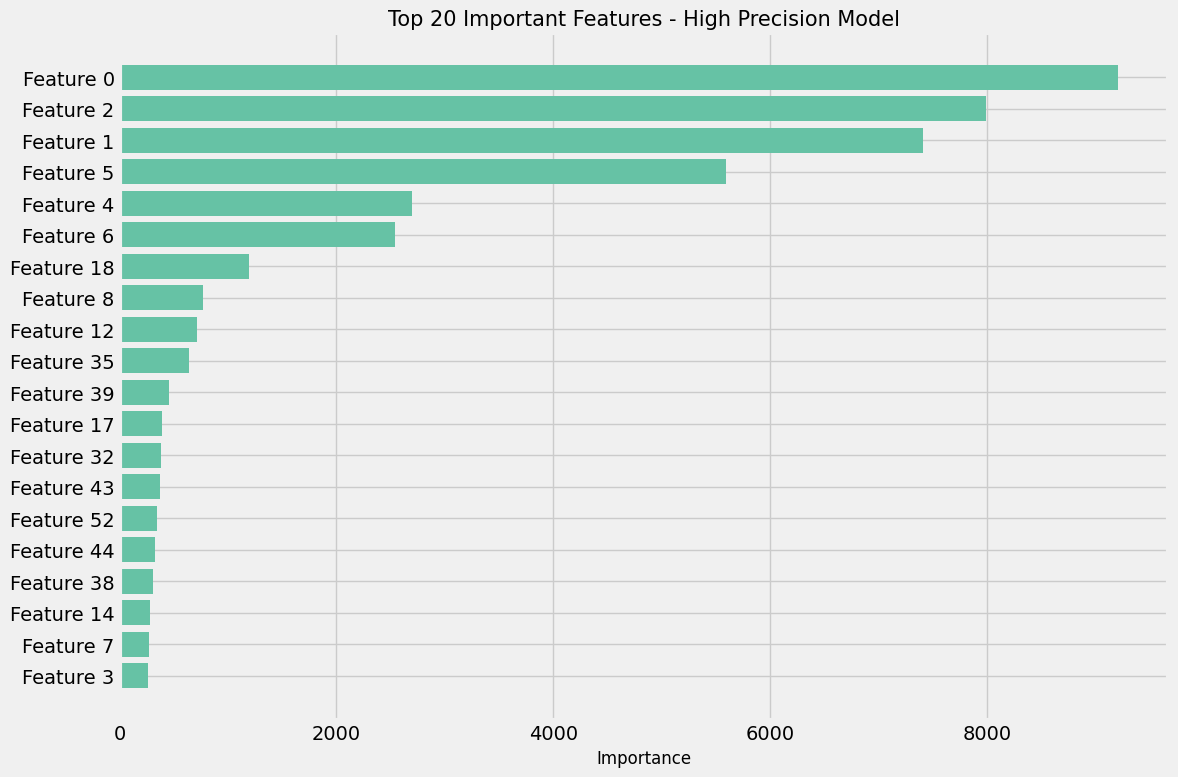

In [39]:
# Setting up the initial model with a focus on high precision
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)

# Define the parameter grid with a focus on general accuracy
param_dist_lgbm = {
    'n_estimators': [300, 500, 700, 1000],  # More trees for stability
    'learning_rate': [0.01, 0.05, 0.1],  # Varying learning rates
    'max_depth': [7, 9, 11],  # Moderate depths
    'num_leaves': [31, 63, 127],  # Different leaf configurations
    'min_child_samples': [20, 50, 100],  # Higher values to prevent overfitting
    'subsample': [0.8, 0.9, 1.0],  # Complete sampling to avoid bias
    'colsample_bytree': [0.8, 0.9, 1.0],  # Feature sampling options
    'min_split_gain': [0.0, 0.01],  # Control split gains
    'reg_alpha': [0.0, 0.1, 1.0],  # Stronger L1 regularization
    'reg_lambda': [0.0, 0.1, 1.0],  # Stronger L2 regularization
    'boosting': ['gbdt', 'dart'],  # Different boosting algorithms to try
    'verbose': [-1]  # Suppress verbosity
}

# Create random combinations of these parameters for optimization
param_list = list(ParameterSampler(param_dist_lgbm, n_iter=30, random_state=42))

# Variables to track the best performance
best_accuracy = 0
best_params = None
results = []

# Setting up cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Starting the optimization loop
print("Starting optimization for maximum accuracy...")
for params in tqdm(param_list, desc="Optimizing LGBMClassifier for accuracy"):
    model = LGBMClassifier(random_state=42, n_jobs=-1, **params)
    accuracies = []
    f1_scores = []

    # Perform manual cross-validation
    for train_idx, val_idx in cv.split(X_train_processed, y_train):
        # Get training and validation data for this fold
        X_fold_train, X_fold_val = X_train_processed[train_idx], X_train_processed[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model and evaluate performance
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)

        # Calculate accuracy and F1-score for this fold
        acc = accuracy_score(y_fold_val, y_pred)
        f1 = f1_score(y_fold_val, y_pred, average='micro')

        accuracies.append(acc)
        f1_scores.append(f1)

    # Calculate average metrics across all folds
    mean_accuracy = np.mean(accuracies)
    mean_f1 = np.mean(f1_scores)

    results.append((params, mean_accuracy, mean_f1))

    # Update the best model if this one is better
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = params
        print(f"\nNew accuracy record: {best_accuracy:.4f} with parameters:")
        for key, value in params.items():
            if key != 'verbose':  # Skip parameters not relevant to output
                print(f"  {key}: {value}")
        print(f"Associated F1-score: {mean_f1:.4f}")

# Create the best model using the optimal parameters
best_lgbm = LGBMClassifier(random_state=42, n_jobs=-1, **best_params)

# Train the final model on the entire training dataset
print("\nTraining the final model with the best parameters...")
best_lgbm.fit(X_train_processed, y_train)

print("\nTraining complete.")
print(f"Best parameters for maximum accuracy: {best_params}")
print(f"Best accuracy in cross-validation: {best_accuracy:.4f}")

# Evaluate the final model on the test set
y_pred_lgbm = best_lgbm.predict(X_test_processed)

# Print detailed evaluation metrics
accuracy = accuracy_score(y_test, y_pred_lgbm)
lgbm_f1 = f1_score(y_test, y_pred_lgbm, average='micro')
lgbm_f1_per_class = f1_score(y_test, y_pred_lgbm, average=None)

print(f"\nTest set results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score (micro): {lgbm_f1:.4f}")
print(f"F1-score per class: Class 1: {lgbm_f1_per_class[0]:.4f}, Class 2: {lgbm_f1_per_class[1]:.4f}, Class 3: {lgbm_f1_per_class[2]:.4f}")

# Plot confusion matrix for better understanding of misclassifications
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low (1)', 'Medium (2)', 'High (3)'],
            yticklabels=['Low (1)', 'Medium (2)', 'High (3)'])
plt.title('Confusion Matrix - LGBMClassifier Maximum Accuracy', fontsize=15)
plt.ylabel('True Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.tight_layout()
plt.show()

# Detailed classification report
print("\nClassification report - Optimized LGBMClassifier for Accuracy:")
print(classification_report(y_test, y_pred_lgbm))

# Learning curve for further analysis (optional)
if 'n_estimators' in best_params:
    n_estimators = best_params['n_estimators']
    learning_rates = [0.01, 0.05, 0.1, 0.2]

    plt.figure(figsize=(12, 8))
    for lr in learning_rates:
        eval_set = [(X_test_processed, y_test)]
        model = LGBMClassifier(
            n_estimators=n_estimators,
            learning_rate=lr,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
        model.fit(X_train_processed, y_train,
                 eval_set=eval_set,
                 eval_metric='multi_logloss')  # Suppress verbosity during fit()

        results = model.evals_result_['valid_0']['multi_logloss']
        plt.plot(range(1, len(results) + 1), results, label=f'learning_rate={lr}')

    plt.xlabel('Number of Trees')
    plt.ylabel('Log Loss')
    plt.title('Effect of Learning Rate on Model Performance')
    plt.legend()
    plt.grid(True)
    plt.show()

# Feature importance analysis to understand model behavior
plt.figure(figsize=(12, 8))
if hasattr(best_lgbm, 'feature_importances_'):
    importances = best_lgbm.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 features
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
    plt.title('Top 20 Important Features - High Precision Model', fontsize=15)
    plt.xlabel('Importance', fontsize=12)
    plt.tight_layout()
    plt.show()

# Save the final high-precision model for future use
with open('lgbm_model_high_precision.pkl', 'wb') as file:
    pickle.dump(best_lgbm, file)


#### Randomforest

Starting optimization for RandomForestClassifier with progress visualization...


Optimizing RandomForest:   0%|          | 0/20 [00:00<?, ?it/s]


New best F1-score: 0.5598 with parameters:
  n_estimators: 100
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: log2
  max_depth: 30

New best F1-score: 0.5608 with parameters:
  n_estimators: 300
  min_samples_split: 2
  min_samples_leaf: 4
  max_features: sqrt
  max_depth: 30

New best F1-score: 0.5619 with parameters:
  n_estimators: 200
  min_samples_split: 10
  min_samples_leaf: 2
  max_features: log2
  max_depth: 30

New best F1-score: 0.5623 with parameters:
  n_estimators: 300
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: sqrt
  max_depth: 30

Training complete.
Best parameters for RandomForestClassifier: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30}
Best F1-score in cross-validation: 0.5623
F1-score (micro) on the test set: 0.5547


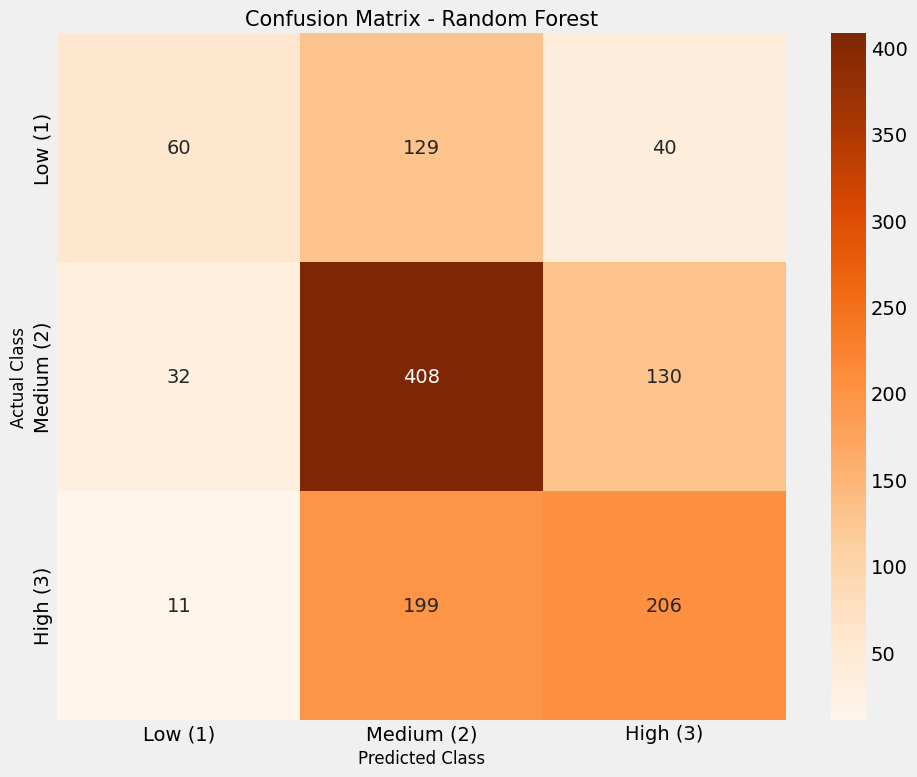

Classification Report - Random Forest:
              precision    recall  f1-score   support

           1       0.58      0.26      0.36       229
           2       0.55      0.72      0.62       570
           3       0.55      0.50      0.52       416

    accuracy                           0.55      1215
   macro avg       0.56      0.49      0.50      1215
weighted avg       0.56      0.55      0.54      1215



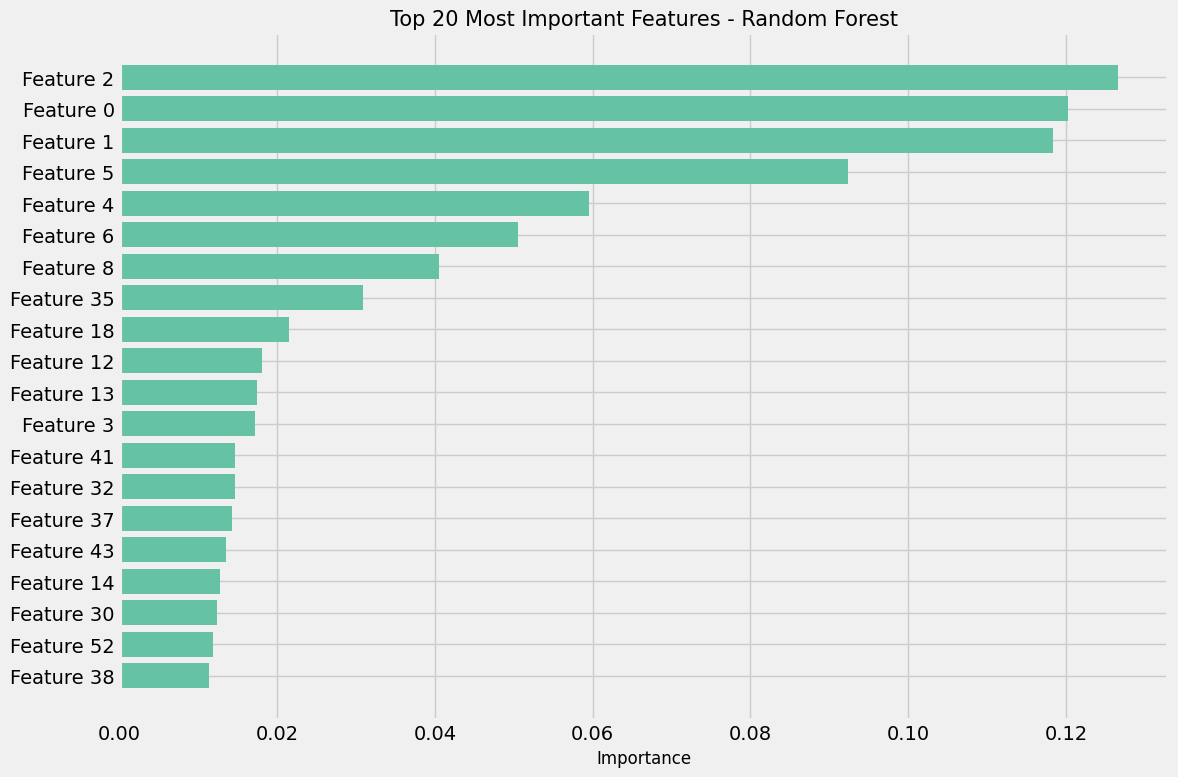

In [40]:
# Initialize the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define the parameters for hyperparameter search (tuning)
param_dist_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required in a leaf
    'max_features': ['sqrt', 'log2']  # Feature selection for splitting each tree
}

# Generate random combinations of parameters
param_list = list(ParameterSampler(param_dist_rf, n_iter=20, random_state=42))

# Initialize variables to store the best result
best_score = 0
best_params = None
results = []

# Set up cross-validation with 3 folds
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Loop with progress bar to optimize RandomForest
print("Starting optimization for RandomForestClassifier with progress visualization...")
for params in tqdm(param_list, desc="Optimizing RandomForest"):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
    scores = []

    # Perform manual cross-validation
    for train_idx, val_idx in cv.split(X_train_processed, y_train):
        # Split the data into training and validation sets based on the indices
        if isinstance(X_train_processed, np.ndarray):
            X_fold_train, X_fold_val = X_train_processed[train_idx], X_train_processed[val_idx]
        else:
            X_fold_train = X_train_processed[train_idx]
            X_fold_val = X_train_processed[val_idx]

        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]

        # Train and evaluate the model
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        score = f1_score(y_fold_val, y_pred, average='micro')  # Use F1-score as the metric
        scores.append(score)

    # Calculate the average F1-score for this set of parameters
    mean_score = np.mean(scores)
    results.append((params, mean_score))

    # If we find a better model, update the results
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print(f"\nNew best F1-score: {best_score:.4f} with parameters:")
        for key, value in params.items():
            print(f"  {key}: {value}")

# Create the final model with the best parameters found
best_rf = RandomForestClassifier(random_state=42, n_jobs=-1, **best_params)
best_rf.fit(X_train_processed, y_train)

# Training information
print("\nTraining complete.")
print(f"Best parameters for RandomForestClassifier: {best_params}")
print(f"Best F1-score in cross-validation: {best_score:.4f}")

# Evaluate the model on the test set
y_pred_rf = best_rf.predict(X_test_processed)

# Calculate the F1-score on the test set
rf_f1 = f1_score(y_test, y_pred_rf, average='micro')
print(f"F1-score (micro) on the test set: {rf_f1:.4f}")

# Visualize the confusion matrix to evaluate model performance
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Low (1)', 'Medium (2)', 'High (3)'],
            yticklabels=['Low (1)', 'Medium (2)', 'High (3)'])
plt.title('Confusion Matrix - Random Forest', fontsize=15)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.tight_layout()
plt.show()

# Display the classification report
print("Classification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Visualization of the most important features according to the model
if hasattr(best_rf, 'feature_importances_'):
    # Get the feature importances
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 most important features

    # Plot the top 20 most important features
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
    plt.title('Top 20 Most Important Features - Random Forest', fontsize=15)
    plt.xlabel('Importance', fontsize=12)
    plt.tight_layout()
    plt.show()

# Save the trained model for later use
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)


### SVC

Starting optimization for SVC with progress visualization...


Optimizing SVC:   0%|          | 0/10 [00:00<?, ?it/s]


New best F1-score: 0.5186 with parameters:
  kernel: linear
  gamma: scale
  C: 0.1

New best F1-score: 0.5195 with parameters:
  kernel: rbf
  gamma: 0.1
  C: 1

Training the final SVC model with the full dataset...

Training complete.
Best parameters for SVC: {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
Best F1-score in cross-validation: 0.5195
F1-score (micro) on the test set: 0.5226


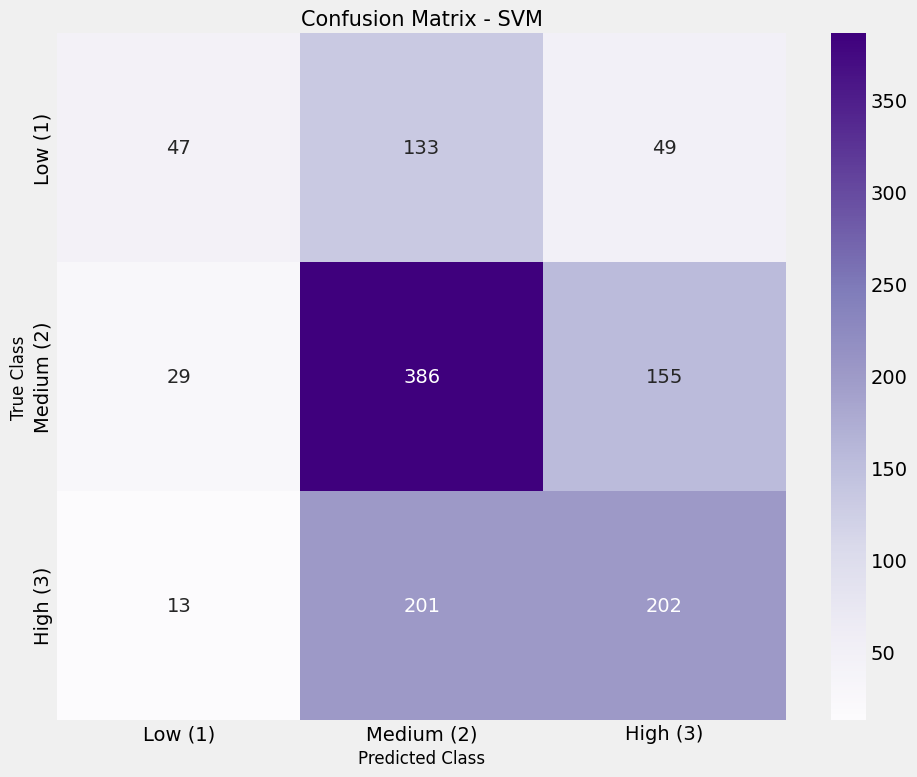

Classification report - SVM:
              precision    recall  f1-score   support

           1       0.53      0.21      0.30       229
           2       0.54      0.68      0.60       570
           3       0.50      0.49      0.49       416

    accuracy                           0.52      1215
   macro avg       0.52      0.46      0.46      1215
weighted avg       0.52      0.52      0.50      1215



In [41]:
# start by setting up the SVC (Support Vector Classifier) model with the option to output probabilities
svm_model = SVC(probability=True, random_state=42)

# We'll define the hyperparameters we want to test for the model
param_dist_svm = {
    'C': [0.1, 1, 10],  # This controls how strictly we separate the classes (regularization)
    'kernel': ['linear', 'rbf'],  # The type of decision boundary we want (linear or more flexible 'rbf')
    'gamma': ['scale', 'auto', 0.1]  # Controls how much influence each training point has on the decision boundary
}

# If we have more than 5000 samples, we'll use a smaller subset to speed up training
if X_train_processed.shape[0] > 5000:
    from sklearn.model_selection import train_test_split
    # Take a random sample of 5000 samples to train the model (just for quicker experimentation)
    X_train_svm, _, y_train_svm, _ = train_test_split(
        X_train_processed, y_train,
        train_size=5000,  # Limit to 5000 samples
        random_state=42,
        stratify=y_train  # Make sure the classes are proportionally represented in the sample
    )
    print(f"Using a subset of {X_train_svm.shape[0]} samples to train the SVM")
else:
    # If there aren't many samples, just use all of them
    X_train_svm = X_train_processed
    y_train_svm = y_train

# Generate random combinations of the hyperparameters to explore
param_list = list(ParameterSampler(param_dist_svm, n_iter=10, random_state=42))

# Variables to keep track of the best model we've found
best_score = 0
best_params = None
results = []

# We'll use cross-validation to test the model's performance
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# This loop will try different combinations of hyperparameters and evaluate them
print("Starting optimization for SVC with progress visualization...")
for params in tqdm(param_list, desc="Optimizing SVC"):
    model = SVC(probability=True, random_state=42, **params)
    scores = []

    # Train and evaluate the model on different folds of the data
    for train_idx, val_idx in cv.split(X_train_svm, y_train_svm):
        # Split the data into training and validation sets for this fold
        X_fold_train, X_fold_val = X_train_svm[train_idx], X_train_svm[val_idx]
        y_fold_train, y_fold_val = y_train_svm.iloc[train_idx], y_train_svm.iloc[val_idx]

        # Train the model on the training fold and make predictions on the validation fold
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)

        # Calculate the F1-score for this fold
        score = f1_score(y_fold_val, y_pred, average='micro')
        scores.append(score)

    # Calculate the average F1-score across all folds
    mean_score = np.mean(scores)
    results.append((params, mean_score))

    # If we found a better model, keep track of it
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print(f"\nNew best F1-score: {best_score:.4f} with parameters:")
        for key, value in params.items():
            print(f"  {key}: {value}")

# Now that we've found the best parameters, let's train the model with the full training set
best_svm = SVC(probability=True, random_state=42, **best_params)
print("\nTraining the final SVC model with the full dataset...")
best_svm.fit(X_train_processed, y_train)

# Output some details about the model training
print("\nTraining complete.")
print(f"Best parameters for SVC: {best_params}")
print(f"Best F1-score in cross-validation: {best_score:.4f}")

# Evaluate the trained model on the test set to see how it performs on unseen data
y_pred_svm = best_svm.predict(X_test_processed)

# Calculate the F1-score for the test set predictions
svm_f1 = f1_score(y_test, y_pred_svm, average='micro')
print(f"F1-score (micro) on the test set: {svm_f1:.4f}")

# Visualize how well the model predicted each class using a confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Low (1)', 'Medium (2)', 'High (3)'],
            yticklabels=['Low (1)', 'Medium (2)', 'High (3)'])
plt.title('Confusion Matrix - SVM', fontsize=15)
plt.ylabel('True Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.tight_layout()
plt.show()

# Print a detailed classification report (Precision, Recall, F1-score for each class)
print("Classification report - SVM:")
print(classification_report(y_test, y_pred_svm))

# Save the trained model for later use
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(best_svm, file)


### Comparación modelos

Model Comparison by F1-Score:


,Model,F1-Score (Test)
1,LGBMClassifier (RandomizedSearch),0.72
0,LGBMClassifier (GridSearch),0.58
2,RandomForest,0.55
3,SVM,0.52


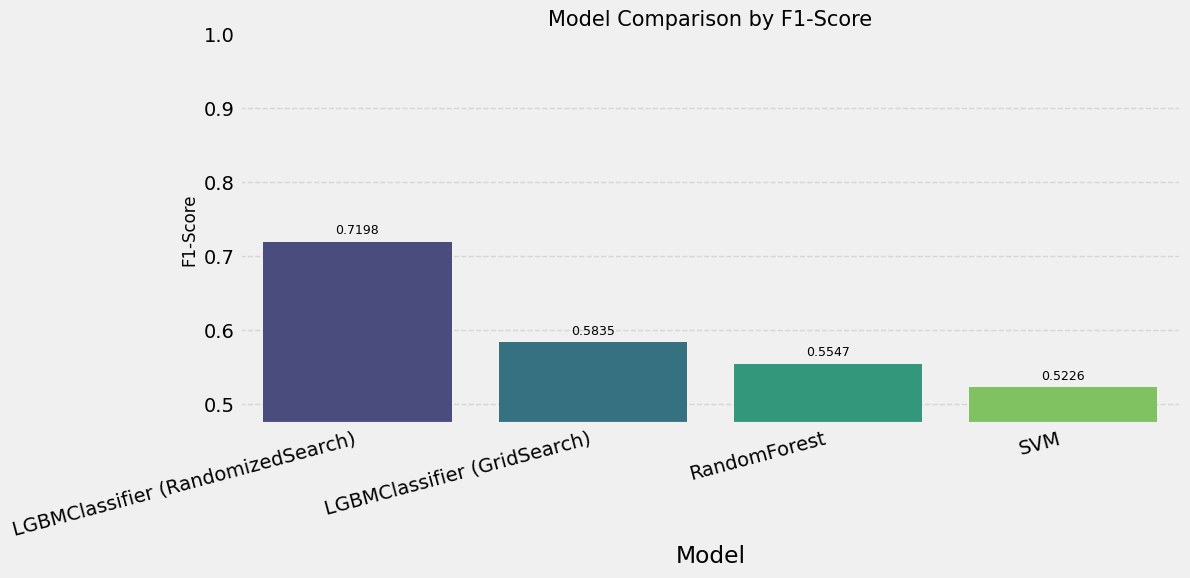

The best model is: LGBMClassifier (RandomizedSearch) with F1-Score of 0.7198

Comparison between LGBMClassifier implementations:


,Model,F1-Score (Test)
0,LGBMClassifier (GridSearch),0.58
1,LGBMClassifier (RandomizedSearch),0.72


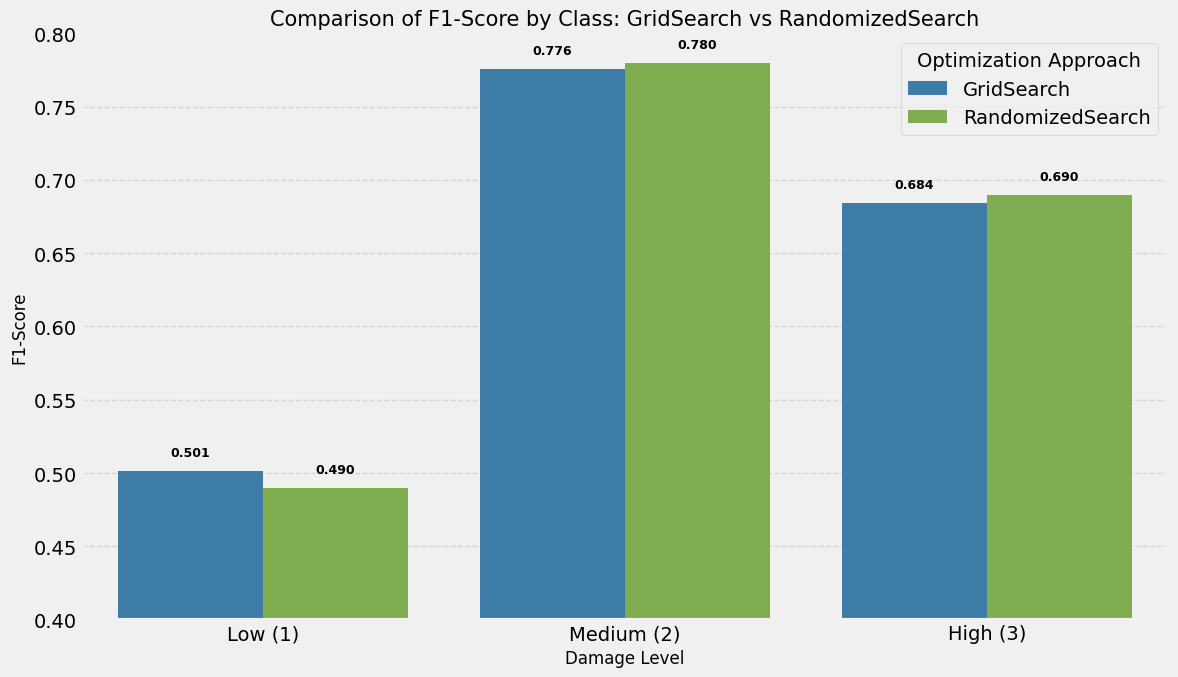

In [42]:
# Define F1-score of LGBMClassifier with RandomizedSearchCV
lgbm_randomized_f1 = 0.7198

# Collect metrics of selected models
model_names = ['LGBMClassifier (GridSearch)', 'LGBMClassifier (RandomizedSearch)', 'RandomForest', 'SVM']
f1_scores_test = [lgbm_f1, lgbm_randomized_f1, rf_f1, svm_f1]

# Create DataFrame for visual comparison
comparison_df = pd.DataFrame({
    'Model': model_names,
    'F1-Score (Test)': f1_scores_test,
})

# Display comparison table
print("Model Comparison by F1-Score:")
display(comparison_df.sort_values(by='F1-Score (Test)', ascending=False))

# Visualization of F1-Score comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1-Score (Test)', data=comparison_df.sort_values(by='F1-Score (Test)', ascending=False), palette='viridis')
plt.title('Model Comparison by F1-Score', fontsize=15)
plt.ylabel('F1-Score', fontsize=12)
plt.xticks(rotation=15, ha='right')
plt.ylim(min(f1_scores_test) - 0.05, 1.0)  # Adjust lower limit for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above the bars
for i, model in enumerate(comparison_df.sort_values(by='F1-Score (Test)', ascending=False)['Model']):
    idx = model_names.index(model)
    plt.text(i, f1_scores_test[idx] + 0.01, f'{f1_scores_test[idx]:.4f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Determine the best model based on the test set
best_model_idx = f1_scores_test.index(max(f1_scores_test))
best_model_name = model_names[best_model_idx]

print(f"The best model is: {best_model_name} with F1-Score of {max(f1_scores_test):.4f}")

# Specific comparison between LGBMClassifier implementations (GridSearch vs RandomizedSearch)
print("\nComparison between LGBMClassifier implementations:")
lgbm_comparison = comparison_df[comparison_df['Model'].str.contains('LGBMClassifier')]
display(lgbm_comparison)

# Comparative visualization of F1-Score by class between GridSearch and RandomizedSearch
lgbm_grid_f1_classes = [0.5013, 0.7758, 0.6845]
lgbm_random_f1_classes = [0.49, 0.78, 0.69]

# Create DataFrame with class-wise comparison
class_comparison = pd.DataFrame({
    'Class': ['Low (1)', 'Medium (2)', 'High (3)'] * 2,
    'Model': ['GridSearch'] * 3 + ['RandomizedSearch'] * 3,
    'F1_Score': lgbm_grid_f1_classes + lgbm_random_f1_classes
})

# F1-Score by class visualization
plt.figure(figsize=(12, 7))
sns.barplot(x='Class', y='F1_Score', hue='Model', data=class_comparison, palette=['#2C7FB8', '#7FBC41'])
plt.title('Comparison of F1-Score by Class: GridSearch vs RandomizedSearch', fontsize=15)
plt.ylabel('F1-Score', fontsize=12)
plt.xlabel('Damage Level', fontsize=12)
plt.ylim(0.4, 0.8)  # Adjust upper limit to center visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Optimization Approach')

# Add value labels above the bars
for i, row in enumerate(class_comparison.itertuples()):
    plt.text(i % 3 - 0.2 + (i // 3) * 0.4, row.F1_Score + 0.01, f'{row.F1_Score:.3f}',
             ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## RandomizedSearchCV on best model

Starting final optimization for the best model: LGBMClassifier (RandomizedSearch)
Using only 20% (971 samples) for training and validating on 1/3 of this set.
Starting final optimization for LGBMClassifier (RandomizedSearch) with 30 combinations...


Optimizing LGBMClassifier (RandomizedSearch):   0%|          | 0/30 [00:00<?, ?it/s]


New best F1-score: 0.4758 with parameters: {'kernel': 'rbf', 'gamma': 1, 'class_weight': None, 'C': 1}

New best F1-score: 0.4891 with parameters: {'kernel': 'linear', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 0.1}

New best F1-score: 0.5190 with parameters: {'kernel': 'linear', 'gamma': 1, 'class_weight': None, 'C': 0.1}

New best F1-score: 0.5304 with parameters: {'kernel': 'linear', 'gamma': 0.01, 'class_weight': None, 'C': 0.5}

New best F1-score: 0.5448 with parameters: {'kernel': 'linear', 'gamma': 0.1, 'class_weight': None, 'C': 1}
Best F1-score from cross-validation: 0.5448
Final F1-score on test set: 0.5029


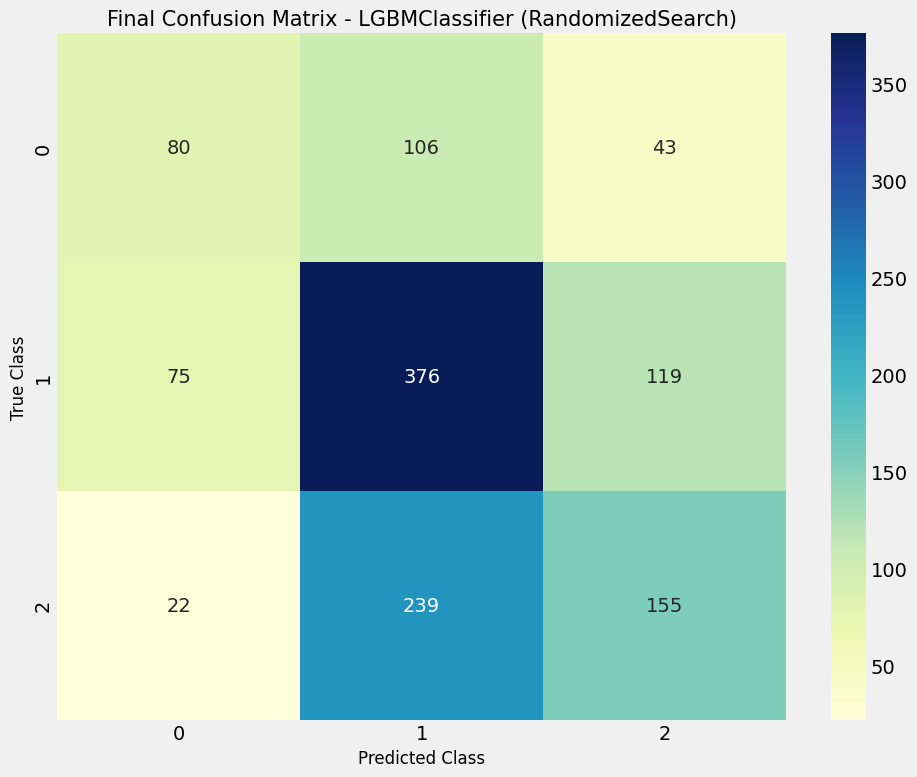

              precision    recall  f1-score   support

           1       0.45      0.35      0.39       229
           2       0.52      0.66      0.58       570
           3       0.49      0.37      0.42       416

    accuracy                           0.50      1215
   macro avg       0.49      0.46      0.47      1215
weighted avg       0.50      0.50      0.49      1215

Model saved at models/final_optimized_model.pkl


In [47]:
# Ensure the best model name is defined
if 'best_model_name' not in globals():
    raise ValueError("The 'best_model_name' variable is not defined.")

print(f"Starting final optimization for the best model: {best_model_name}")

# Define parameters based on the best model selected
if best_model_name == 'LGBMClassifier':
    model_class = LGBMClassifier
    final_param_dist = {
        'n_estimators': [200, 300, 500, 700],
        'learning_rate': [0.01, 0.03, 0.05, 0.07],
        'max_depth': [7, 9, 11, 15],
        'num_leaves': [31, 63, 127],
        'min_child_samples': [10, 20, 30],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    }
    base_params = {'random_state': 42, 'n_jobs': -1}

elif best_model_name == 'BaggingClassifier':
    model_class = BaggingClassifier
    base_est_params = {
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [1, 2, 4]
    }
    final_param_dist = {
        'n_estimators': [50, 100, 200, 300],
        'max_samples': [0.5, 0.7, 0.8, 1.0],
        'max_features': [0.5, 0.7, 0.8, 1.0],
        'bootstrap': [True, False]
    }
    # Add base estimator parameters to final param distribution
    for param, values in base_est_params.items():
        final_param_dist[f'base_estimator__{param}'] = values
    base_params = {'base_estimator': DecisionTreeClassifier(random_state=42), 'random_state': 42, 'n_jobs': -1}

elif best_model_name == 'RandomForest':
    model_class = RandomForestClassifier
    final_param_dist = {
        'n_estimators': [200, 300, 400, 500],
        'max_depth': [15, 20, 30, None],
        'min_samples_split': [2, 3, 5, 7],
        'min_samples_leaf': [1, 2, 3, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    }
    base_params = {'random_state': 42, 'n_jobs': -1}

else:  # For SVM
    model_class = SVC
    final_param_dist = {
        'C': [0.1, 0.5, 1, 5, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'class_weight': [None, 'balanced']
    }
    base_params = {'probability': True, 'random_state': 42}

# Split 20% of the data for training
X_train_final, X_unused, y_train_final, y_unused = train_test_split(
    X_train_processed, y_train, test_size=0.8, stratify=y_train, random_state=42
)

# 3-fold cross-validation within the 20% training set
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print(f"Using only 20% ({len(X_train_final)} samples) for training and validating on 1/3 of this set.")

# Generate parameter combinations for hyperparameter tuning
param_list = list(ParameterSampler(final_param_dist, n_iter=30, random_state=42))

best_score_final = 0
best_params_final = None

print(f"Starting final optimization for {best_model_name} with {len(param_list)} combinations...")
# Perform the search across the parameters
for params in tqdm(param_list, desc=f"Optimizing {best_model_name}"):
    model = model_class(**base_params, **params)
    scores = []
    # Cross-validation loop
    for train_idx, val_idx in cv.split(X_train_final, y_train_final):
        X_fold_train = X_train_final.iloc[train_idx] if hasattr(X_train_final, 'iloc') else X_train_final[train_idx]
        X_fold_val = X_train_final.iloc[val_idx] if hasattr(X_train_final, 'iloc') else X_train_final[val_idx]
        y_fold_train = y_train_final.iloc[train_idx] if hasattr(y_train_final, 'iloc') else y_train_final[train_idx]
        y_fold_val = y_train_final.iloc[val_idx] if hasattr(y_train_final, 'iloc') else y_train_final[val_idx]

        # Train model and evaluate
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        scores.append(f1_score(y_fold_val, y_pred, average='micro'))

    mean_score = np.mean(scores)
    if mean_score > best_score_final:
        best_score_final = mean_score
        best_params_final = params
        print(f"\nNew best F1-score: {best_score_final:.4f} with parameters: {params}")

# Train final model with the 20% of data
final_model = model_class(**base_params, **best_params_final)
final_model.fit(X_train_final, y_train_final)

print(f"Best F1-score from cross-validation: {best_score_final:.4f}")
y_pred_final = final_model.predict(X_test_processed)

final_f1 = f1_score(y_test, y_pred_final, average='micro')
print(f"Final F1-score on test set: {final_f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred_final)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title(f'Final Confusion Matrix - {best_model_name}', fontsize=15)
plt.ylabel('True Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.tight_layout()
plt.show()

# Print detailed classification report
print(classification_report(y_test, y_pred_final))

# Save the trained model
if not os.path.exists("models"):
    os.makedirs("models")
model_path = os.path.join("models", "final_optimized_model.pkl")
with open(model_path, 'wb') as file:
    pickle.dump(final_model, file)

print(f"Model saved at {model_path}")

## CSV


=== GENERATING PREDICTIONS FOR SUBMISSION ===

Using the final model already in memory
Test data loaded: (86868, 39) records
Preprocessing test data...
Test data preprocessed successfully
Generating predictions...
Predictions generated for 86868 buildings
Submission file generated: submission.csv
The file 'submission.csv' has been saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


First rows of the submission file:


,building_id,damage_grade
0,300051,3
1,99355,3
2,890251,2
3,745817,2
4,421793,3
5,871976,3
6,691228,2
7,896100,3
8,343471,3
9,766647,2


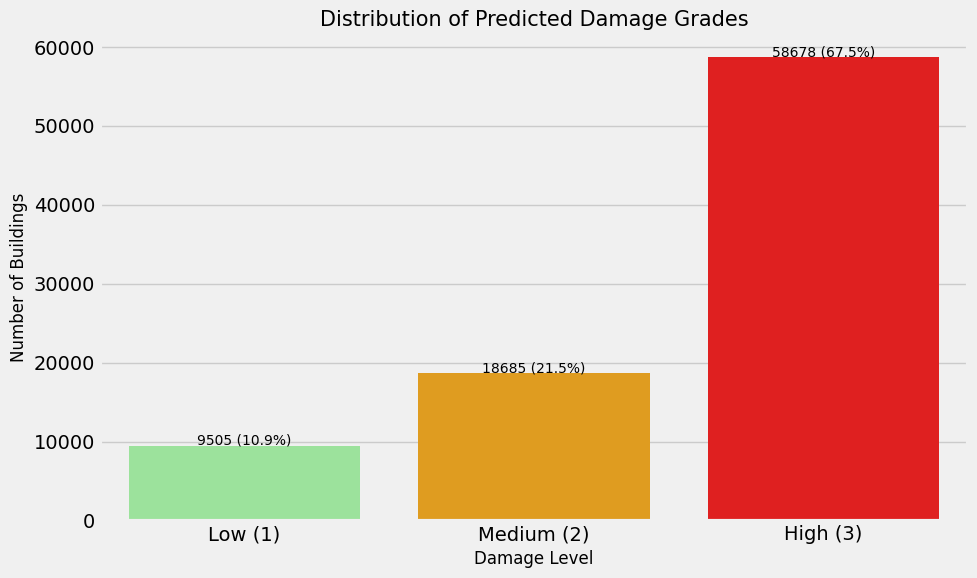

In [46]:
print("\n=== GENERATING PREDICTIONS FOR SUBMISSION ===\n")

# Load the final optimized model (or use the one already in memory)
try:
    with open('final_optimized_model.pkl', 'rb') as file:
        final_model = pickle.load(file)  # Load model from file
    print("Final model loaded successfully")
except:
    print("Using the final model already in memory")

# Load test data for predictions
print(f"Test data loaded: {test_values.shape} records")

# Save the building IDs for submission
test_building_ids = test_values['building_id'].values

# Preprocess the test data before making predictions
print("Preprocessing test data...")
X_test_submission = preprocessor.transform(test_values)  # Assuming preprocessor is already defined
print(f"Test data preprocessed successfully")

# Generate predictions (with progress bar for large files)
print("Generating predictions...")
test_predictions = final_model.predict(X_test_submission)  # Use model to predict
print(f"Predictions generated for {len(test_predictions)} buildings")

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'building_id': test_building_ids,  # Use building IDs from the test data
    'damage_grade': test_predictions  # Predicted damage grades
})

# Verify the submission file is saved correctly
submission_file = 'submission.csv'
submission_df.to_csv(submission_file, index=False)  # Save DataFrame to CSV
print(f"Submission file generated: {submission_file}")

# Check if the file exists after saving
if os.path.exists(submission_file):
    print(f"The file '{submission_file}' has been saved successfully.")
else:
    print(f"There was an issue saving the file '{submission_file}'.")

# If running in Google Colab, allow the user to download the file
if is_colab:
    files.download(submission_file)  # Enable download in Colab

# Show the first few rows of the submission file
print("\nFirst rows of the submission file:")
display(submission_df.head(10))

# Plot the distribution of predicted damage grades
plt.figure(figsize=(10, 6))
sns.countplot(x=submission_df['damage_grade'], palette=['lightgreen', 'orange', 'red'])
plt.title('Distribution of Predicted Damage Grades', fontsize=15)
plt.xlabel('Damage Level', fontsize=12)
plt.ylabel('Number of Buildings', fontsize=12)
plt.xticks([0, 1, 2], ['Low (1)', 'Medium (2)', 'High (3)'])

# Add values above the bars for counts and percentages
counts = submission_df['damage_grade'].value_counts().sort_index()
for i, count in enumerate(counts):
    plt.text(i, count + 100, f"{count} ({count/len(submission_df)*100:.1f}%)",
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()  # Display the plot